Code d'analyse de tracking. Il permet de récupérer les fichiers issus du tracking et d'en tirer les trajectoires pertinentes et d'en faire l'étude statistique. 

In [893]:
%reset

In [894]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  1 12:46:56 2023.

@author: souchaud
"""
# %%
import os
import time
import math
import pandas as pd
import numpy as np
from skimage import io
from PIL import Image
from scipy.stats import norm
from scipy import stats
from scipy.signal import find_peaks
from scipy.optimize import curve_fit, minimize_scalar
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec
import trackpy as tp
import functions_analyze as lib
import warnings
import importlib
from collections import defaultdict
from colorama import init, Fore, Style
from typing import List, Optional, Union, Any, Dict, Tuple
importlib.reload(lib)

init(autoreset=True)
# from matplotlib.cm import ScalarMappable
# import pdb; pdb.set_trace()
# warnings.simplefilter("always")  # This will always display warnings
# warnings.simplefilter('error', RuntimeWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

Initialisation des variables et constantes de travail.

In [895]:
# set initial time
INITIAL_TIME = time.time()

# experiment parameters
TIME_FRAME = 15 # 15  # 75
SIZE_PIX = 0.637# 1.2773  # 1.634  # 4.902
FPS = 1/TIME_FRAME

# File to study
file_name = 'features'  # 'filtered'Any
# number of frame kept
N_FRAME = 3
N_FRAME_MIN_STUDY = 210  # Nombre minimal de frame sur laquelle la cellule doit être suivie

# nber hours of stydy:
LONG_TIME = False

# Study parameters
ROLLING_MEAN = False
PIXELISATION = False
TIME_FRAME_STUDY = False
DRIFT = False

# plot parameters
IMG_TYPE = 'jpg'
ALPHA = 0.5
LINEWIDTH = 0.1
COLOR_SUP = 'blue'
COLOR_INF = 'red'
color_sup_inf = (COLOR_SUP, COLOR_INF)

# % de présences de la particules sur le total de frame étudiées

FRAME_PARTICULE = 1

# ##########
# % de présences des courbes dans les frames

FRAME_PARTICULE = 0.8

Définition des path et dossiers de travails / enregistrements.

In [896]:
# ##########################   GENERAL PATH   #################################
GENERAL_PATH = '/Users/souchaud/Desktop/Analyses/'
GENERAL_PATH_PICTURES = '/Users/souchaud/Desktop/A_analyser/'
# GENERAL_PATH_PICTURES = '/Volumes/Labo_Alex_Mac/A_analyser/'

In [897]:
############# CONDITION SIMPLE ################
# CONDITION_simple = 'CytoOne_SorC'
# CONDITION_simple = 'NonT_SorC'
CONDITION_simple = 'CytoOne_HL5_10x'
# CONDITION_simple = 'CytoOne_HL5'

############### CONDITION ################
CONDITION = f'{CONDITION_simple}_new_param' # _longtime_new_param'
# CONDITION = 'ASMOT035_fiji'
###########################################

In [898]:
# list of pathway to the experiments
PATHWAY_EXPERIMENT = []

if len(PATHWAY_EXPERIMENT) == 0:
    PATHWAY_EXPERIMENT = [f for f in os.listdir(GENERAL_PATH + CONDITION) if
                          os.path.isdir(os.path.join(GENERAL_PATH + CONDITION, f))]
# ##########################   Path Exp final  ###############################

PATHWAY_EXPERIMENT = [f'{GENERAL_PATH}{CONDITION}/' +
                      elem + '/mosaic/' for elem in PATHWAY_EXPERIMENT]

# ##########################   Path to Save pic  ##############################

path_save_pic = f'{GENERAL_PATH}résultats_{CONDITION}_ALL_OK_x5_15s/'

# création d'un dossier spécific d'enregistrement.
if not os.path.exists(path_save_pic):
    os.mkdir(path_save_pic)
os.chdir(path_save_pic)

Lecture des données expériementales

In [899]:
importlib.reload(lib)
DATA = lib.read_hdf5_all(pathway_experiment=PATHWAY_EXPERIMENT, name_file=file_name,
                         nbr_frame_min=N_FRAME_MIN_STUDY, condition=CONDITION, drift=DRIFT,
                         search_range=20, memory=30)

Frame 339: 120 trajectories present.
ASMOT110  :  113
Nombre de particules récoltées avant tri:  285


On décide de travailler que sur un certain nombre de frame. Ici je décide de travailler sur les 240 première frames. 
Donc la cellules doit être suivi sur N_MIN_STUDY sur les 240 premières frames. 

In [900]:
print("Nombre de particule avant tri: ", DATA['particle'].nunique())
DATA = DATA[DATA['frame'] < 340]

filter_data = DATA.groupby('particle').filter(lambda x: len(x) >= N_FRAME_MIN_STUDY)
print("Nombre de particule après le premier tri sur le temps suivi des cellules: ", filter_data['particle'].nunique())
DATA = filter_data

Nombre de particule avant tri:  285
Nombre de particule après le premier tri sur le temps suivi des cellules:  285


In [901]:
DATA['time (min)'] = DATA['frame']*TIME_FRAME/60
DATA = lib.vit_instant_new(traj=DATA, lag_time=TIME_FRAME, pix_size=SIZE_PIX, triage=1)
DATA

y            x          mass       size       ecc     signal  \
0      5758.592806  4232.189285   8005.447600  13.870742  0.239629  33.013871   
1      5753.784793  4228.609340   8633.288213  16.241964  0.187569  33.043688   
2      5756.489645  4223.077870   7650.588790  14.486532  0.253940  38.311780   
3      5757.200866  4220.336577   6426.628459  12.370441  0.090581  32.506415   
4      5765.462990  4222.450295   9785.415989  15.459541  0.172221  33.067581   
...            ...          ...           ...        ...       ...        ...   
91201  4026.112532  4326.002768  19362.547814  12.276114  0.025119  41.220298   
91202  4026.744299  4326.769061  19107.699477  12.346610  0.025529  40.185594   
91203  4028.233239  4326.374204  18276.941252  12.588558  0.040358  37.240086   
91204  4028.782743  4325.472323  17454.730621  13.008251  0.042919  32.383027   
91205  4028.978475  4323.936046  17102.755978  13.418842  0.048050  29.200493   

       raw_mass        ep  frame  old_particle  count  particle experiment  \
0      301672.0  0.521247      0             1    280         0   ASMOT115   
1      301490.0  0.528546      1             1    280         0   ASMOT115   
2      301163.0  0.539082      2             1    280         0   ASMOT115   
3      298296.0  0.674077      3             1    280         0   ASMOT115   
4      303426.0  0.465335      4             1    280         0   ASMOT115   
...         ...       ...    ...           ...    ...       ...        ...   
91201  353099.0  0.522756    335           195    211       284   ASMOT110   
91202  352865.0  0.534479    336           195    211       284   ASMOT110   
91203  351637.0  0.573137    337           195    211       284   ASMOT110   
91204  349672.0  0.664387    338           195    211       284   ASMOT110   
91205  349128.0  0.694150    339           195    211       284   ASMOT110   

                                                position  \
0      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
1      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
2      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
3      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
4      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
...                                                  ...   
91201  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
91202  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
91203  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
91204  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
91205  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   

                       condition  time (min)  dx [pix]  dy [pix]  \
0      CytoOne_HL5_10x_new_param        0.00       NaN       NaN   
1      CytoOne_HL5_10x_new_param        0.25 -3.579944 -4.808013   
2      CytoOne_HL5_10x_new_param        0.50 -5.531471  2.704852   
3      CytoOne_HL5_10x_new_param        0.75 -2.741293  0.711221   
4      CytoOne_HL5_10x_new_param        1.00  2.113719  8.262124   
...                          ...         ...       ...       ...   
91201  CytoOne_HL5_10x_new_param       83.75  0.647161  2.869551   
91202  CytoOne_HL5_10x_new_param       84.00  0.766294  0.631767   
91203  CytoOne_HL5_10x_new_param       84.25 -0.394857  1.488940   
91204  CytoOne_HL5_10x_new_param       84.50 -0.901881  0.549504   
91205  CytoOne_HL5_10x_new_param       84.75 -1.536277  0.195732   

       displacement [pix]  VitInst [um/min]  
0                     NaN               NaN  
1                5.994413         15.273764  
2                6.157385         15.689017  
3                2.832053          7.216070  
4                8.528218         21.729898  
...                   ...               ...  
91201            2.941622          7.495254  
91202            0.993145          2.530532  
91203            1.540407          3.924957  
91204            1.056098          2.690939  
91205            1.548696          3.946077  

[91206 rows x 20

In [902]:
DATA = DATA.query(f'frame % {N_FRAME} == 0')
DATA['frame'] = pd.factorize(DATA['frame'])[0]
FPS = FPS/N_FRAME
DATA

/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_55089/672234316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['frame'] = pd.factorize(DATA['frame'])[0]


y            x          mass       size       ecc     signal  \
0      5758.592806  4232.189285   8005.447600  13.870742  0.239629  33.013871   
3      5757.200866  4220.336577   6426.628459  12.370441  0.090581  32.506415   
6      5769.679427  4221.699928  12307.225161  16.076941  0.203709  44.646736   
9      5771.106475  4224.374556  11161.989438  16.055196  0.191326  31.696406   
12     5767.874475  4205.394935   7583.114185  13.499714  0.242127  33.266629   
...            ...          ...           ...        ...       ...        ...   
91193  4017.080519  4324.347011  16428.101404  13.390161  0.067599  29.096986   
91196  4018.387096  4326.136116  17105.619688  12.827203  0.019922  32.655342   
91199  4022.039503  4324.991778  17879.551186  12.738875  0.026931  35.577080   
91202  4026.744299  4326.769061  19107.699477  12.346610  0.025529  40.185594   
91205  4028.978475  4323.936046  17102.755978  13.418842  0.048050  29.200493   

       raw_mass        ep  frame  old_particle  count  particle experiment  \
0      301672.0  0.521247      0             1    280         0   ASMOT115   
3      298296.0  0.674077      1             1    280         0   ASMOT115   
6      313632.0  0.287907      2             1    280         0   ASMOT115   
9      305639.0  0.411651      3             1    280         0   ASMOT115   
12     294869.0  0.964445      4             1    280         0   ASMOT115   
...         ...       ...    ...           ...    ...       ...        ...   
91193  348972.0  0.701642    109           195    211       284   ASMOT110   
91196  350374.0  0.631706    110           195    211       284   ASMOT110   
91199  351329.0  0.589626    111           195    211       284   ASMOT110   
91202  352865.0  0.534479    112           195    211       284   ASMOT110   
91205  349128.0  0.694150    113           195    211       284   ASMOT110   

                                                position  \
0      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
3      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
6      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
9      /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
12     /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
...                                                  ...   
91193  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
91196  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
91199  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
91202  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   
91205  /Users/souchaud/Desktop/Analyses/CytoOne_HL5_1...   

                       condition  time (min)   dx [pix]  dy [pix]  \
0      CytoOne_HL5_10x_new_param        0.00        NaN       NaN   
3      CytoOne_HL5_10x_new_param        0.75  -2.741293  0.711221   
6      CytoOne_HL5_10x_new_param        1.50   1.247972  1.146978   
9      CytoOne_HL5_10x_new_param        2.25   0.905102 -0.474341   
12     CytoOne_HL5_10x_new_param        3.00 -11.098434 -5.741943   
...                          ...         ...        ...       ...   
91193  CytoOne_HL5_10x_new_param       81.75   1.121882 -0.150690   
91196  CytoOne_HL5_10x_new_param       82.50   0.879368  0.215248   
91199  CytoOne_HL5_10x_new_param       83.25  -0.724205  2.524099   
91202  CytoOne_HL5_10x_new_param       84.00   0.766294  0.631767   
91205  CytoOne_HL5_10x_new_param       84.75  -1.536277  0.195732   

       displacement [pix]  VitInst [um/min]  
0                     NaN               NaN  
3                2.832053          7.216070  
6                1.694991          4.318837  
9                1.021865          2.603712  
12              12.495805         31.839312  
...                   ...               ...  
91193            1.131957          2.884226  
91196            0.905329          2.306777  
91199            2.625938          6.690890  
91202            0.993145          2.530532  
91205            1.548696          3.946077  

[305

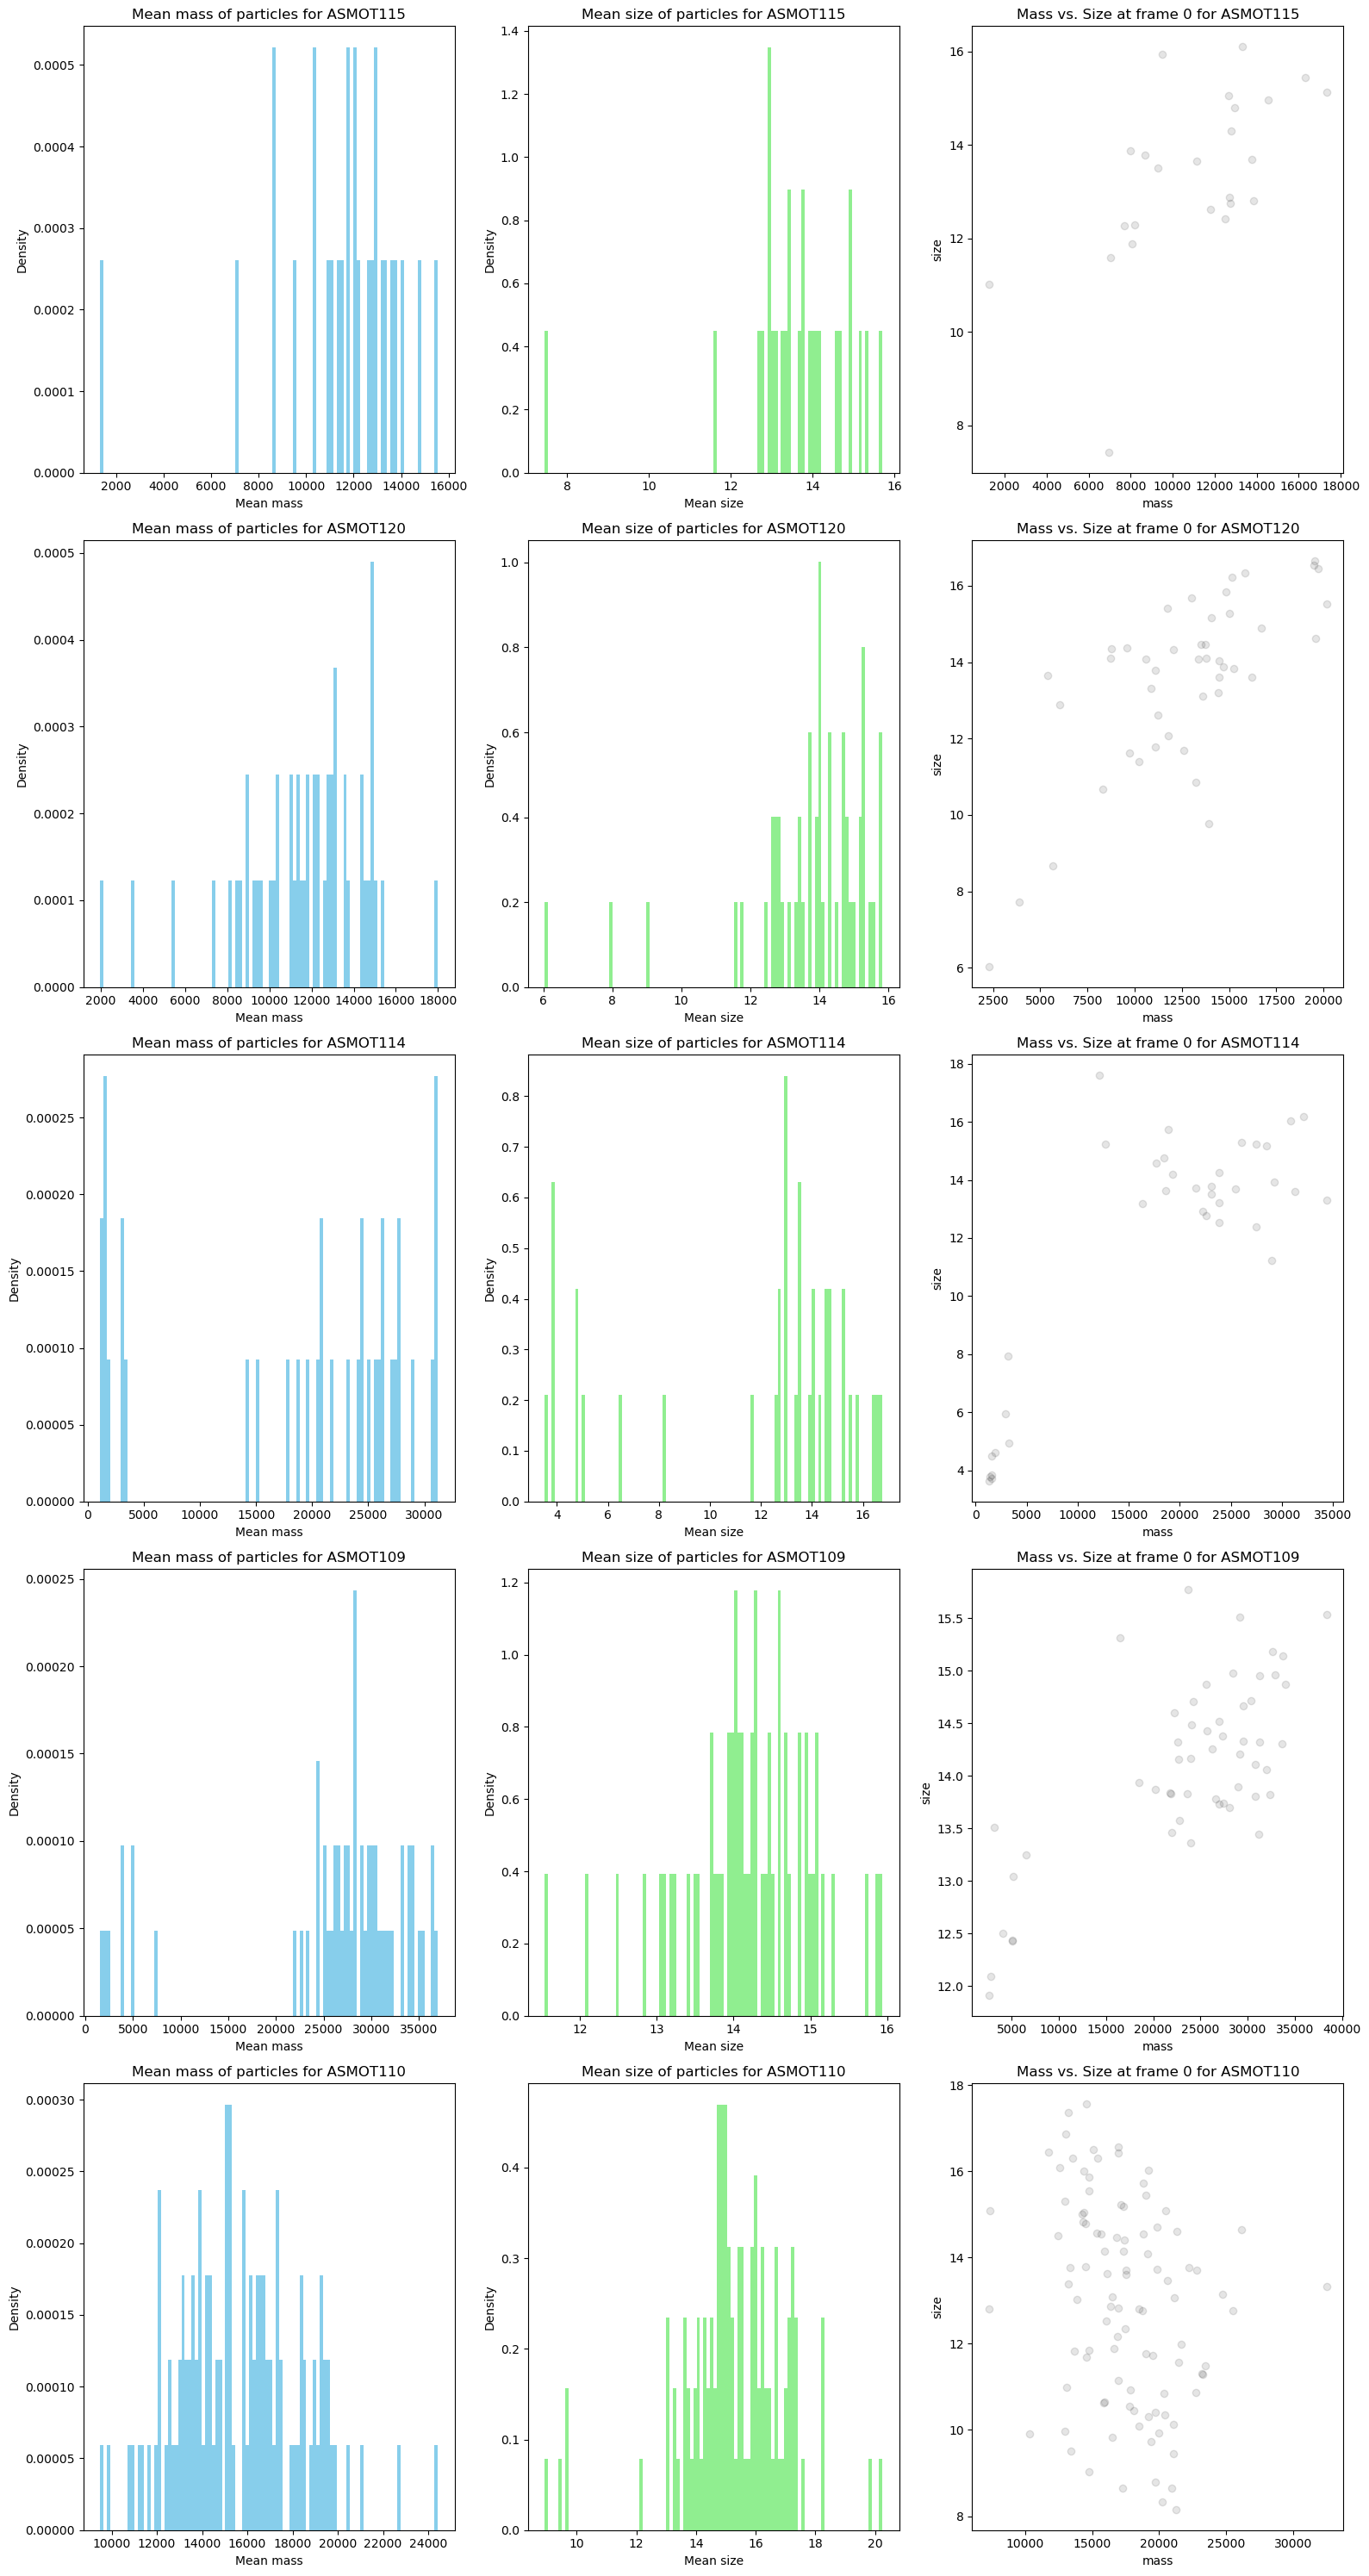

In [903]:
# Supposons que DATA est votre DataFrame et qu'il contient une colonne 'manip' pour identifier chaque manipulation
manips = DATA['experiment'].unique()
num_manips = len(manips)

# Créer une figure pour accueillir tous les subplots
fig = plt.figure(figsize=(16, 6*num_manips))

# Créer un gridspec pour mieux organiser les subplots
gs = gridspec.GridSpec(num_manips, 3, fig)

colors = ['skyblue', 'lightgreen', 'salmon']  # Couleurs pour les différents types de graphiques

for i, manip in enumerate(manips):
    data_manip = DATA[DATA['experiment'] == manip]
    mass_means = data_manip.groupby('particle')['mass'].mean()
    size_means = data_manip.groupby('particle')['size'].mean()

    # Masse moyenne
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.hist(mass_means, bins=100, color=colors[0], density=True)
    ax1.set_title(f"Mean mass of particles for {manip}")
    ax1.set_xlabel("Mean mass")
    ax1.set_ylabel("Density")

    # Taille moyenne
    ax2 = fig.add_subplot(gs[i, 1])
    ax2.hist(size_means, bins=100, color=colors[1], density=True)
    ax2.set_title(f"Mean size of particles for {manip}")
    ax2.set_xlabel("Mean size")
    ax2.set_ylabel("Density")

    # Mass vs. Size au frame 0
    filtered_data = data_manip[data_manip['frame'] == 0]
    ax3 = fig.add_subplot(gs[i, 2])
    tp.mass_size(filtered_data, ax=ax3)
    ax3.set_title(f"Mass vs. Size at frame 0 for {manip}")

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher la figure
plt.show()


In [904]:
# # In[Filter on mass]
# if 'mass' in DATA.columns:
#     mask = DATA.groupby('particle')['mass'].transform('mean') >= 1000
#     DATA = DATA[mask]
# if 'level_0' in DATA.columns:
#     DATA = DATA.drop('level_0', axis=1)
# DATA.reset_index(inplace=True)
# # In[Compute some datas as instant displacement /speed / centering trajectories ...]


On trace le nombre de particules par frame en fonction du temps pour chaque manips. Ca permets de repérer des anomalies. 

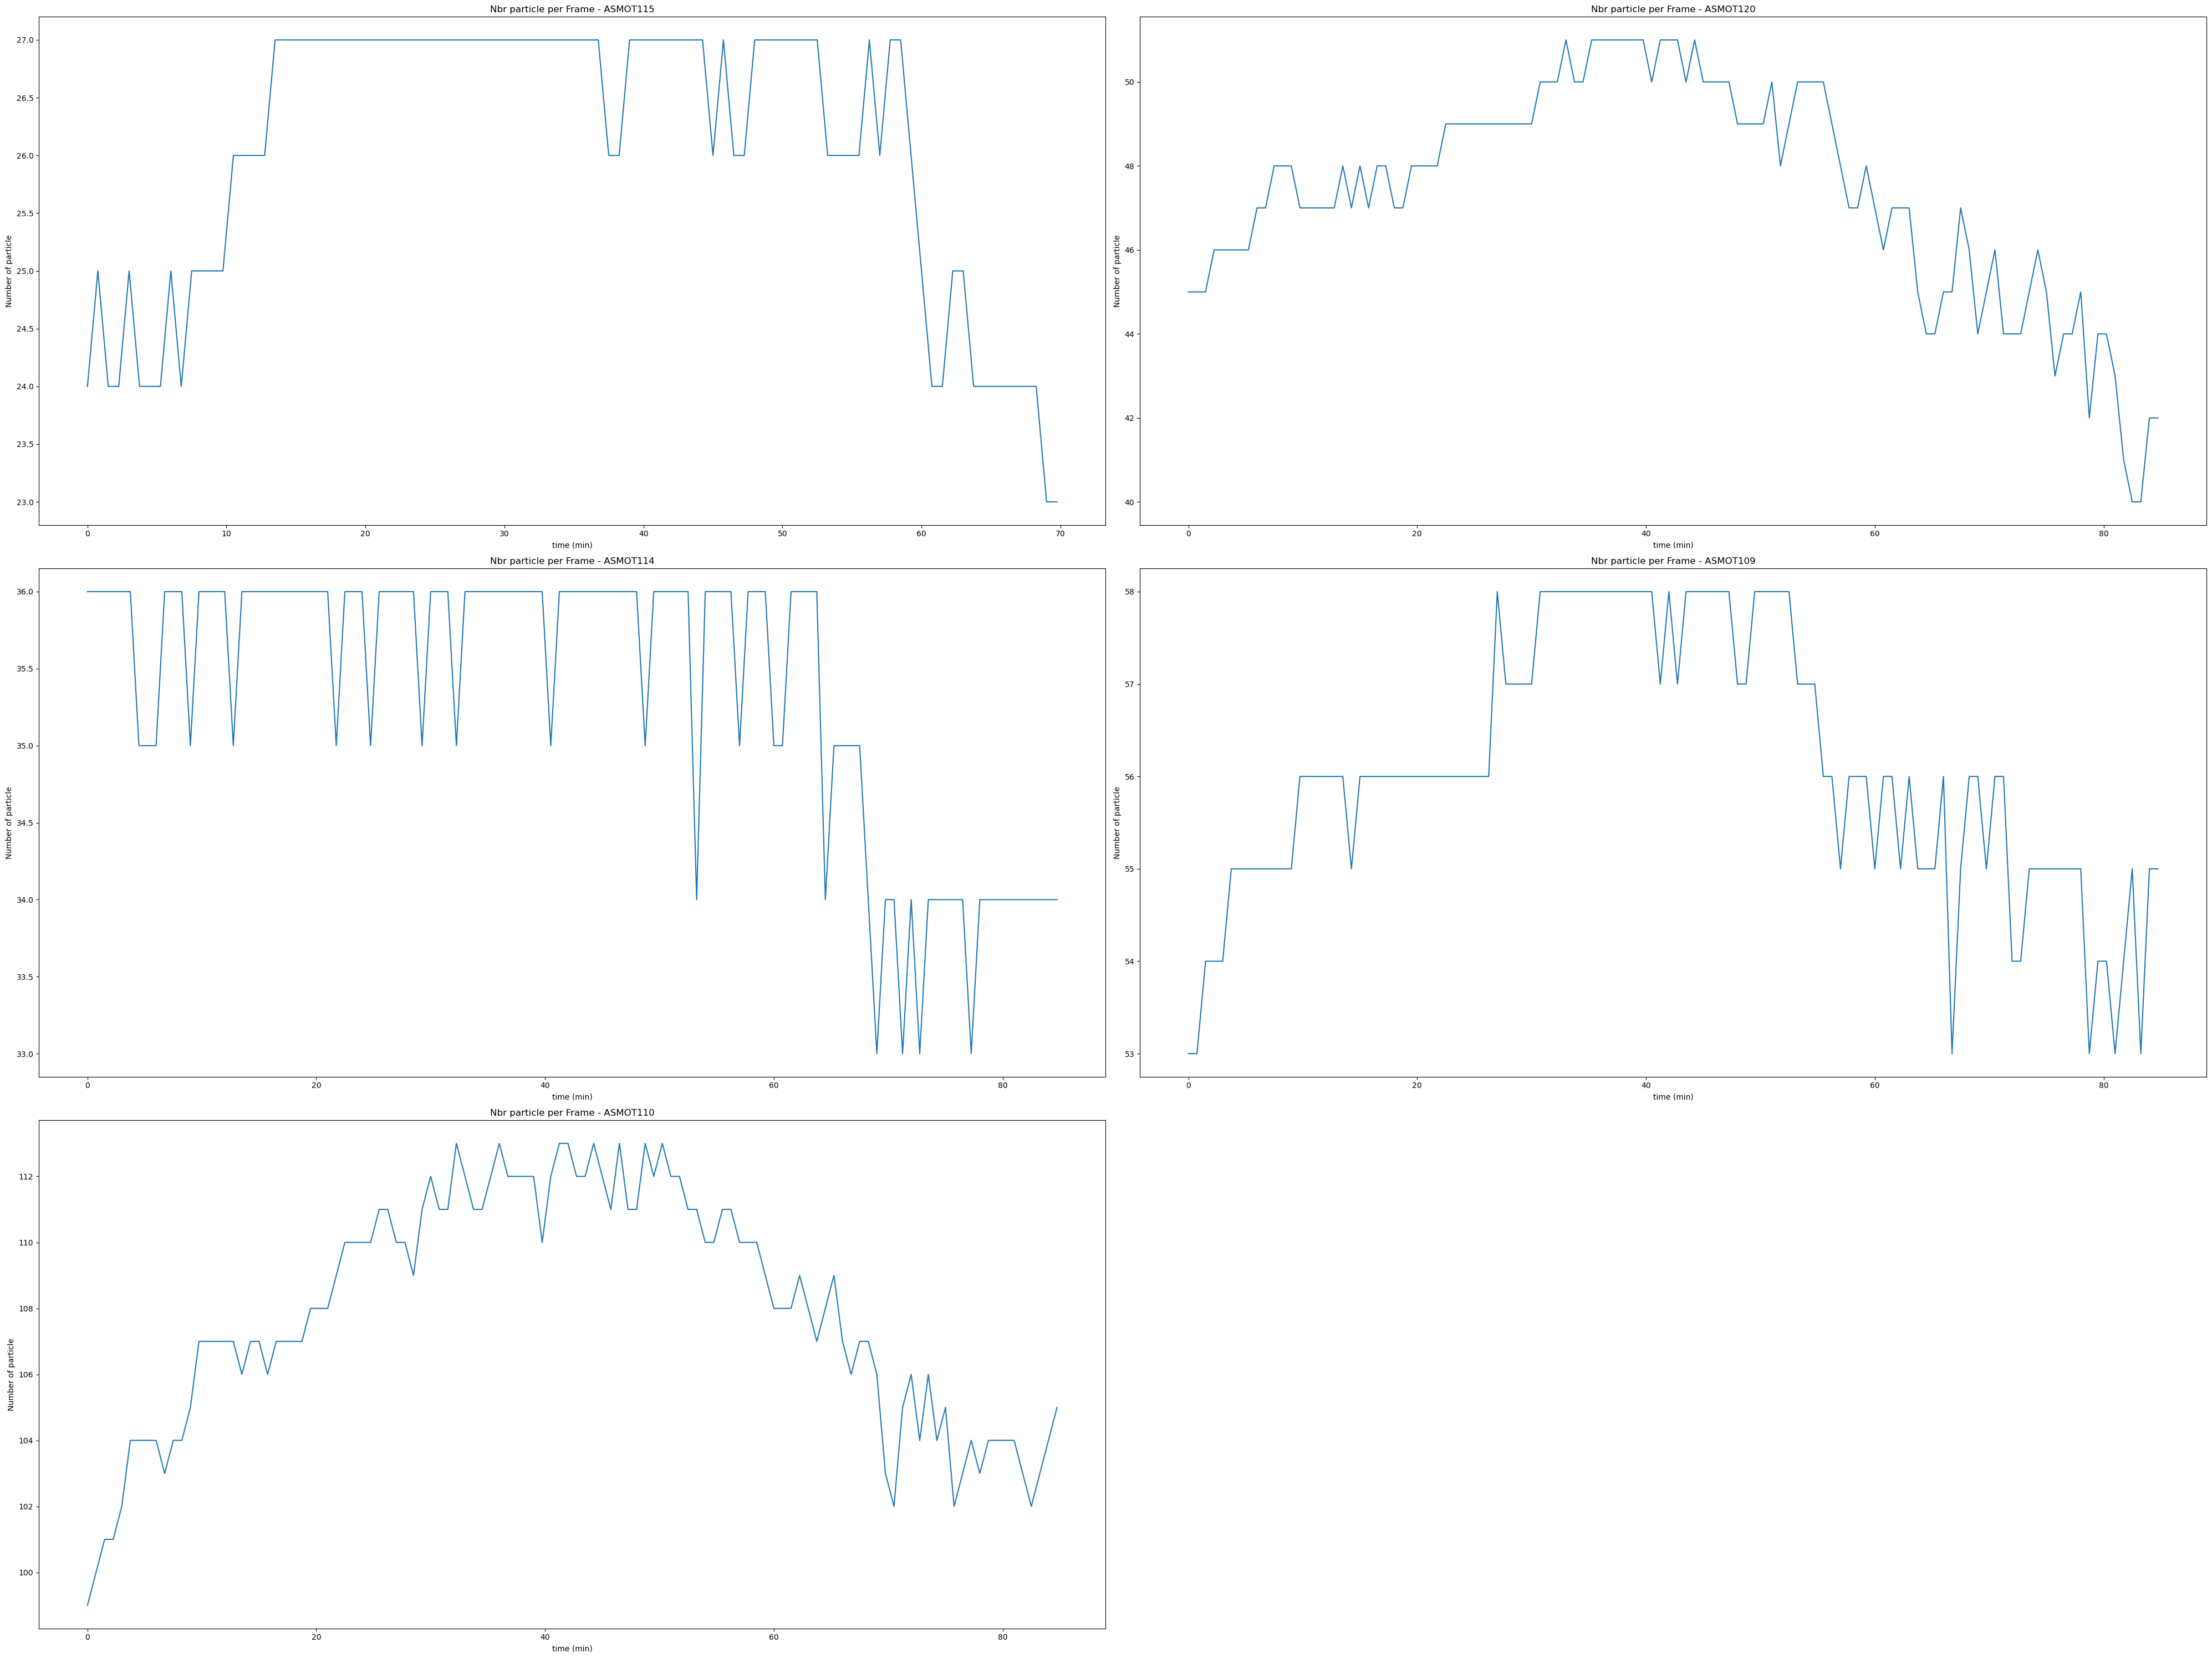

In [905]:
# Obtenir les expériences uniques pour les itérations
experiments = DATA['experiment'].unique()

# Déterminer le nombre de lignes et de colonnes pour les sous-graphiques
# Vous pouvez ajuster cela en fonction du nombre total d'expériences
n_cols = 2  # Nombre de colonnes, ajustez selon le besoin
n_rows = (len(experiments) + n_cols - 1) // n_cols  # Nombre de lignes

# Créer une figure et des axes pour les sous-graphiques
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20 * n_cols, 10 * n_rows))
axs = axs.flatten()  # Aplatir le tableau d'axes si nécessaire

# Tracer les graphiques pour chaque expérience
for i, exp in enumerate(experiments):
    # Grouper les données par 'frame' et calculer le nombre de particules par frame
    nbr_part_per_frame = DATA[DATA['experiment'] == exp].groupby('time (min)')['particle'].nunique()

    # Tracer le graphique sur le sous-graphique correspondant
    ax = axs[i]
    ax.plot(nbr_part_per_frame.index, nbr_part_per_frame.values)
    ax.set_title(f'Nbr particle per Frame - {exp}')
    ax.set_xlabel('time (min)')
    ax.set_ylabel('Number of particle')
    # ax.set_xlim([0, 340])
    # ax.set_ylim([0, 2000])  # Ajustez selon vos données

# Masquer les axes non utilisés s'il y en a
for ax in axs[len(experiments):]:
    ax.axis('off')

# Ajustement de la mise en page
plt.tight_layout()
# Ajustement de l'espacement et des marges
# plt.subplots_adjust(hspace=0.4, wspace=0.4)
# Enregistrer la figure entière
plt.savefig(f"{path_save_pic}Nbr_particle_per_Frame_manip_par_manip.jpg", format='jpg')

# Afficher la figure
plt.show()


In [906]:
# Example usage
path_data = lib.calculate_total_path_first_frames(DATA, first_n_frames=100)

/Users/souchaud/Desktop/Dictyostelium/Motility/Analyse_tracking/tracking_and_analyze/functions_analyze.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['total_path_first_n'] = dataframe['particle'].map(total_paths)


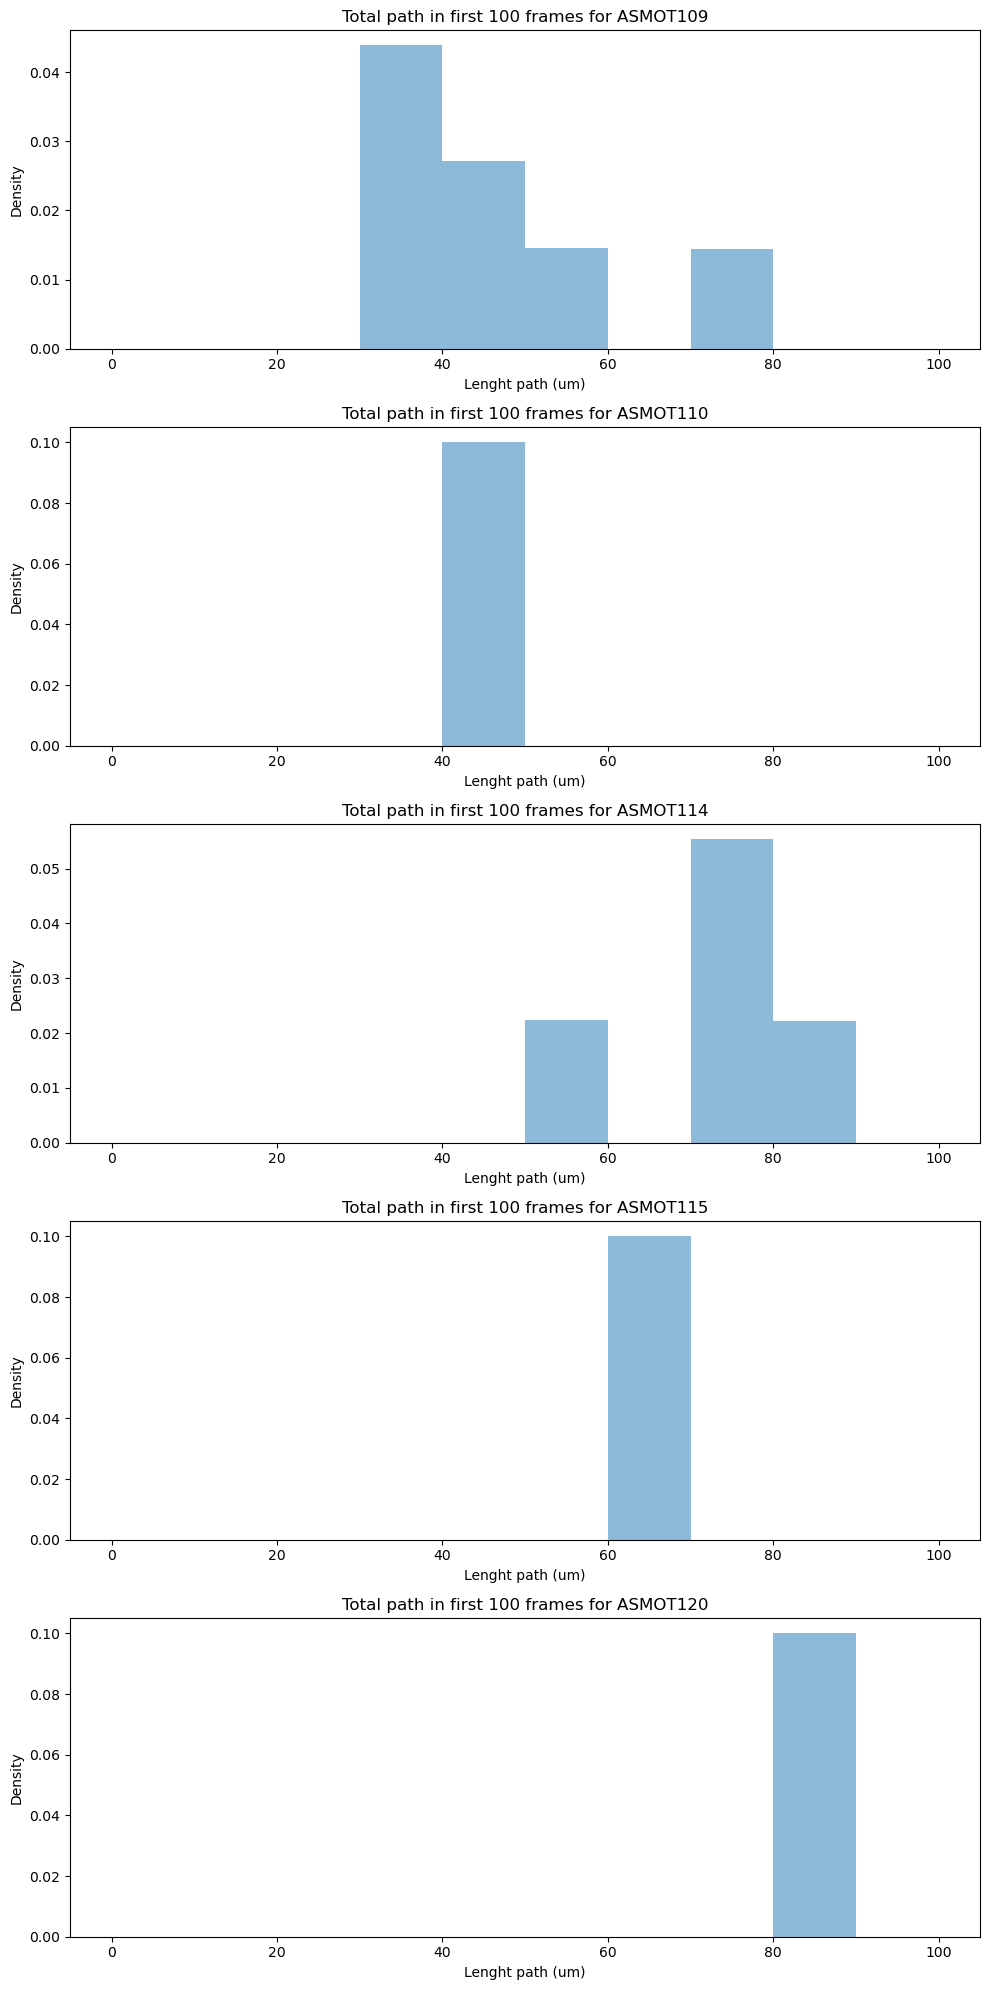

In [907]:
import matplotlib.pyplot as plt
import pandas as pd

# Grouper les données par 'experiment'
grouped = path_data.groupby('experiment')

# Calculer le nombre d'experiments pour déterminer le nombre de subplots nécessaires
n_experiments = len(grouped)

# Créer une figure et des axes pour les subplots
fig, axes = plt.subplots(nrows=n_experiments, figsize=(10, 4*n_experiments))

# Assurer que 'axes' est un array, même s'il n'y a qu'un seul subplot
if n_experiments == 1:
    axes = [axes]

for (experiment, group), ax in zip(grouped, axes):
    # Créer un histogramme pour chaque 'experiment'
    ax.hist(group['total_path_first_n'], bins=10, range=[0, 100], density=True, alpha=0.5)
    ax.set_title(f"Total path in first 100 frames for {experiment}")
    ax.set_xlabel('Lenght path (um)')
    ax.set_ylabel('Density')

# Ajuster l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()

# Afficher la figure
plt.show()


Calcul du nombre de cellules ayant un déplacement inférieur à une valeur.

In [908]:
# Nombre de cellules avec un déplacement total inférieur à 10 sur les 20 premières frames
num_cells_low_displacement = path_data[path_data['total_path_first_n'] < 15]['particle'].nunique()

print("Nombre de cellules dont le déplacement est trop faible : " , num_cells_low_displacement)

Nombre de cellules dont le déplacement est trop faible :  0


In [909]:
# # Get the indices of rows to drop
# to_drop = find_swaps_with_return(DATA)

# print(len(to_drop), " movements to delete there while the run is too much.")

# # # Drop the rows from DATA
# DATA = DATA.drop(to_drop)
DATA.reset_index(inplace=True)

Calcul des vitesses instantanées et des trajectoires recentrées

In [910]:
# DATA = DATA[DATA['displacement [pix]'] < 5]
DATA = lib.center(traj=DATA)

print("\n"*2)
print(f"Le temps de lecture et de préparation des données pour la condition {CONDITION} est : ",
      (time.time() - INITIAL_TIME), 'min')
print("\n"*2)

/Users/souchaud/Desktop/Dictyostelium/Motility/Analyse_tracking/tracking_and_analyze/functions_analyze.py:754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traj['X0 [pix]'] = [x_zero[part] for part in traj['particle']]
/Users/souchaud/Desktop/Dictyostelium/Motility/Analyse_tracking/tracking_and_analyze/functions_analyze.py:756: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traj['Y0 [pix]'] = [y_zero[part] for part in traj['particle']]
/Users/souchaud/Desktop/Dictyostelium/Motility/Analyse_tracking/tracking




Le temps de lecture et de préparation des données pour la condition CytoOne_HL5_10x_new_param est :  11.475455045700073 min





In [911]:
# %% [Compute the DATAS according to some parameters]
if ROLLING_MEAN:
    DATA = lib.rolling_mean(datas=DATA, roll=3)
if PIXELISATION:
    DATA = lib.pixelisation(datas=DATA, size_pix=SIZE_PIX)
if TIME_FRAME_STUDY:
    DATA, TIME_FRAME = lib.keep_nth_image(traj=DATA, n=N_FRAME, time_frame=TIME_FRAME)

In [912]:
# #############################################################################
# %% [Calculation of total and cumulative displacement]
# #############################################################################
DATA, start_end = lib.length_displacement(traj=DATA, size_pix=SIZE_PIX)

In [913]:
# # %% [Recalcul du max displacement]
# # ###################Erasing the suspicious displacements #####################
# grouped_data = DATA.groupby('particle')
# # Obtenir la valeur maximale de 'displacement' pour chaque groupe
# max_displacements = SIZE_PIX*grouped_data['displacement [pix]'].max()
# # Sélectionner les groupes dont la valeur maximale de 'displacement' est supérieure à 10
# selected_particles = max_displacements.loc[max_displacements > 50].index.tolist()
# bool_mask = DATA['particle'].isin(selected_particles)
# DATA_HIGH_DISP = DATA[bool_mask]
# if len(DATA_HIGH_DISP) > 0:
#     lib.plot_msd(msd=tp.imsd(traj=DATA_HIGH_DISP, mpp=SIZE_PIX, fps=FPS),
#                  fps=FPS, name='MSD with HIGHT DISP (sup at 10)', color_plot=COLOR_SUP,
#                  save=True, pathway_saving=path_save_pic, alpha=ALPHA, linewidth=LINEWIDTH)
# # Erasing the spurious traectories with too high displacement
# DATA = DATA[~bool_mask]

# #############################################################################
# #############################################################################
# We now Consider having all the good particles and all good datas.
# #############################################################################
# #############################################################################

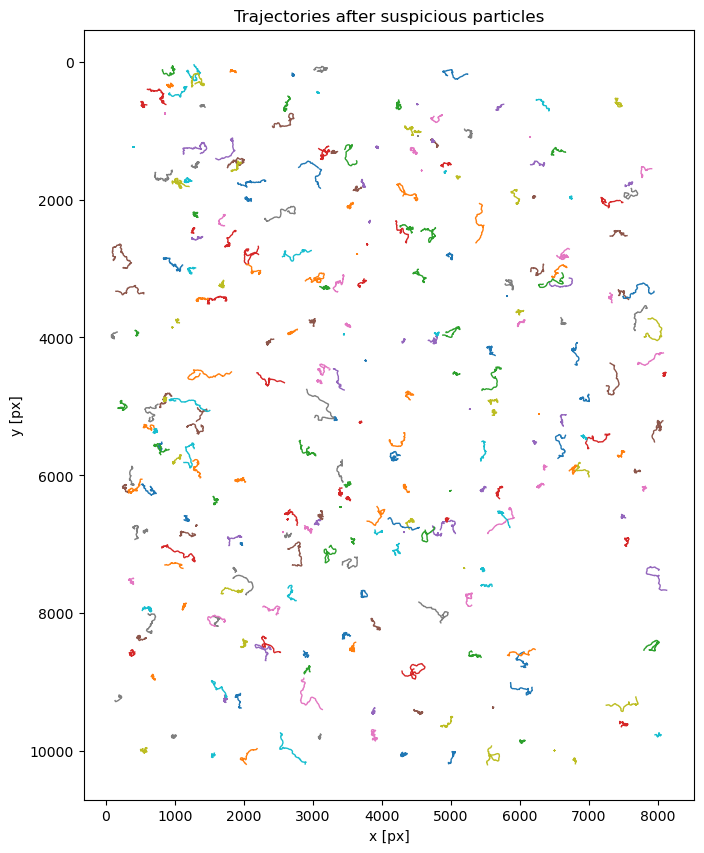

In [914]:
# %% [Plot all the trajectories]
fig, axis = plt.subplots(figsize=(10, 10))
# Assurer une échelle égale pour les axes
axis.set_aspect('equal', 'box')
plt.title('Trajectories after suspicious particles')
tp.plot_traj(DATA, label=(False))
plt.show()
fig.savefig(path_save_pic +
            'Trajectories after removing suspicious particles.jpg', format='jpg')

In [915]:
# Construire le chemin complet
image_path = os.path.join(GENERAL_PATH_PICTURES, CONDITION_simple)
image_path = image_path + '_faits'
print(image_path)

/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x_faits


/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_55089/1052518327.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path_directory)
/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_55089/1052518327.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path_directory)


No directory found for ASMOT114


/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_55089/1052518327.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path_directory)
/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_55089/1052518327.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path_directory)


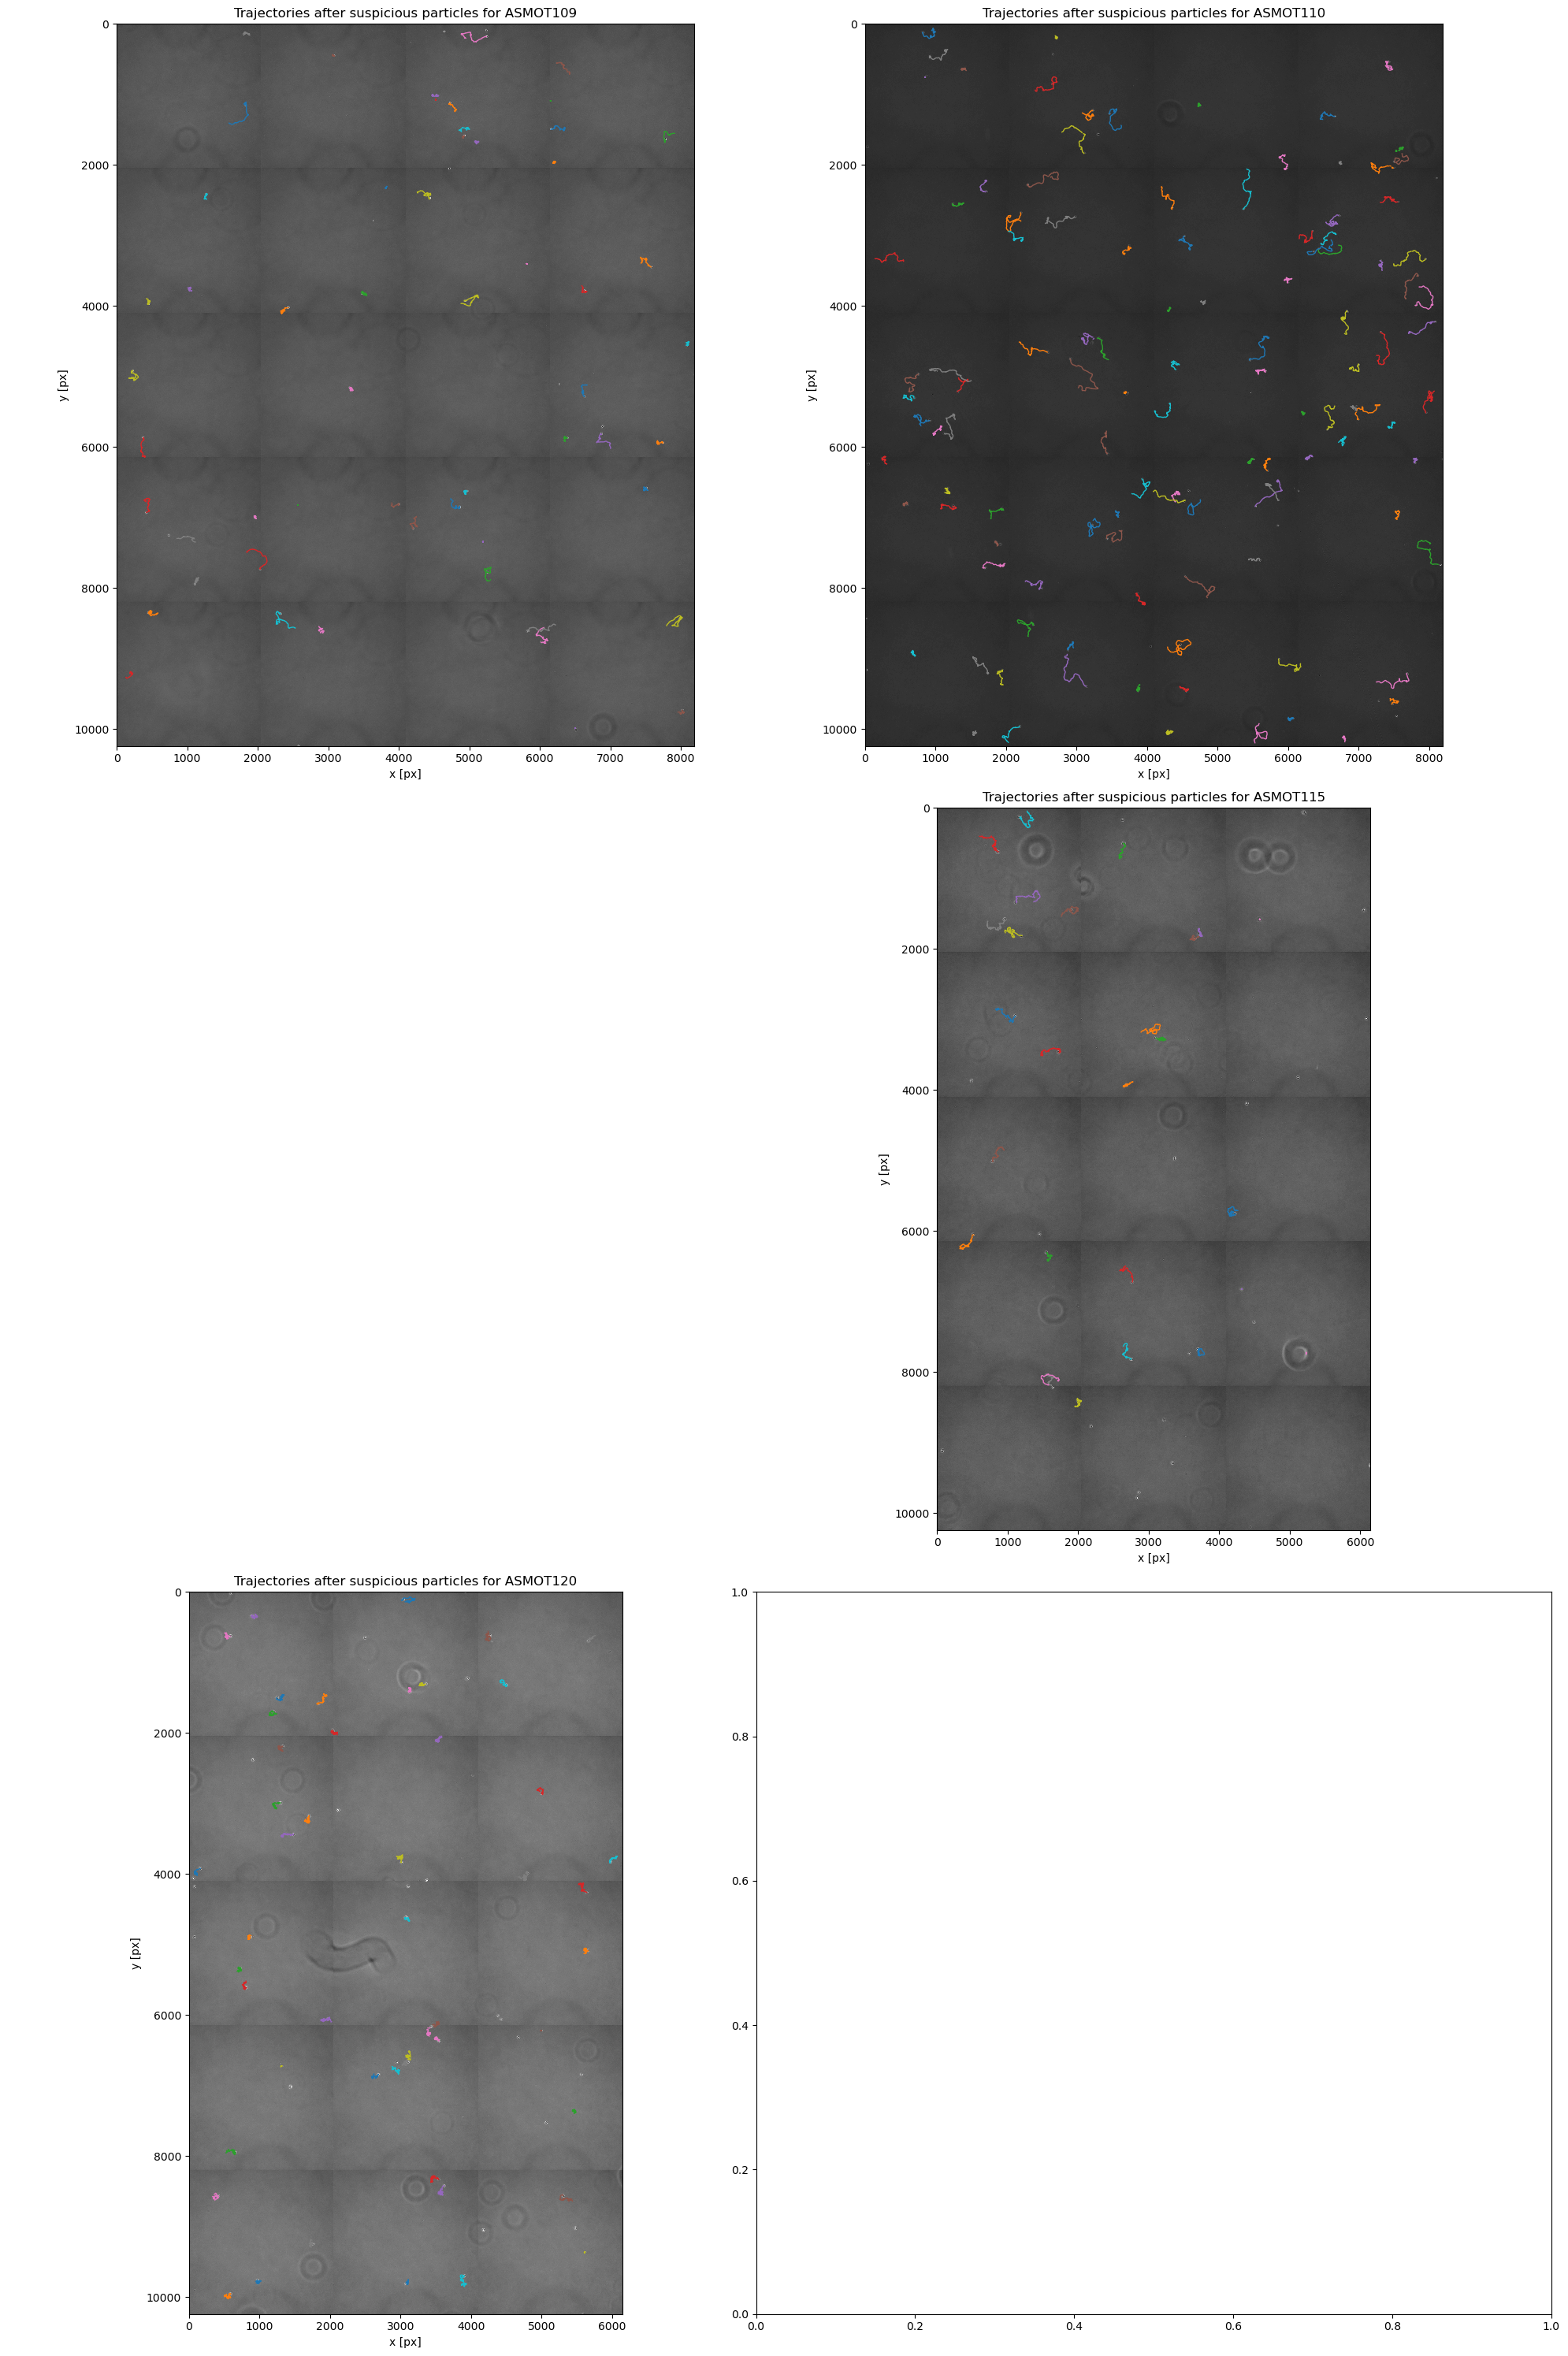

In [916]:
import trackpy as tp
import matplotlib.pyplot as plt

# Supposons que DATA est votre DataFrame
plot_exp = DATA.groupby('experiment')

# Déterminer le nombre de sous-graphiques basé sur le nombre d'expériences
num_experiments = len(plot_exp)
num_cols = 2  # Par exemple, vous pouvez définir 2 colonnes pour vos sous-graphiques
num_rows = (num_experiments + num_cols - 1) // num_cols  # Calculer le nombre de lignes nécessaire

# Créer la figure et les axes pour les sous-graphiques
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 10))  # Ajustez la taille selon vos besoins
axes = axes.flatten()  # Aplatir le tableau d'axes pour une itération facile

for ax, (exp_name, exp_data) in zip(axes, plot_exp):
    exp_directories = []
    for dirpath, dirnames, filenames in os.walk(image_path):
        for dirname in dirnames:
            if exp_name in dirname:
                full_path = os.path.join(dirpath, dirname)
                exp_directories.append(full_path)

    if exp_directories:
        image_path_directory = f'{exp_directories[0]}/mosaic/mosaic_total_0.tif'
        frame = imageio.imread(image_path_directory)
        ax.set_aspect('equal', 'box')
        ax.set_title(f'Trajectories after suspicious particles for {exp_name}')
        tp.plot_traj(exp_data, superimpose=frame, label=False, ax=ax)
    else:
        print(f"No directory found for {exp_name}")
        ax.axis('off')
# Ajuster la mise en page pour éviter le chevauchement
plt.tight_layout()
plt.show()
fig.savefig(path_save_pic + 'trajectories_on_frame_all_experiment.pdf', format='pdf')


In [917]:
series_y = DATA.groupby('experiment')['y'].max().div(2048).apply(math.ceil).astype(int)
series_x = DATA.groupby('experiment')['x'].max().div(2048).apply(math.ceil).astype(int)
# Multiplication élément par élément entre les deux séries
result = series_y * series_x

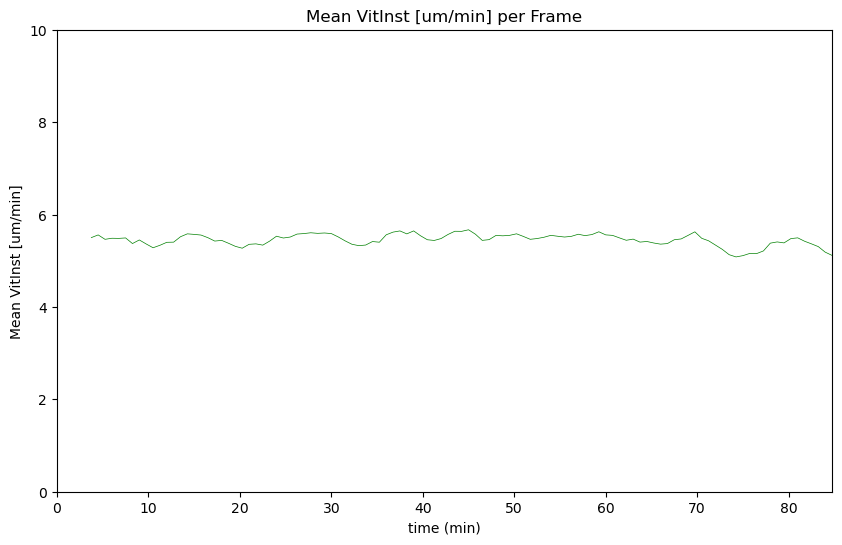

In [918]:
# %% [Mean speed]
# Grouper les données par 'frame' et calculer la moyenne de 'VitInst [um/min]'
mean_VitInst_per_frame = DATA.groupby('time (min)')['VitInst [um/min]'].mean()
mean_VitInst_per_frame.index = mean_VitInst_per_frame.index

mean_VitInst_per_frame = mean_VitInst_per_frame.rolling(5).mean().dropna()

lib.plot_datas(x_values=mean_VitInst_per_frame.index,
               y_values=mean_VitInst_per_frame.values,
               title='Mean VitInst [um/min] per Frame',
               x_label='time (min)', y_label='Mean VitInst [um/min]',
               x_lim=[0, max(mean_VitInst_per_frame.index)], y_lim=[0, 10], save=True,
               path_save_pic=path_save_pic, img_type="jpg")


In [919]:
DATA

index            y            x          mass       size       ecc  \
0          0  5758.592806  4232.189285   8005.447600  13.870742  0.239629   
1          3  5757.200866  4220.336577   6426.628459  12.370441  0.090581   
2          6  5769.679427  4221.699928  12307.225161  16.076941  0.203709   
3          9  5771.106475  4224.374556  11161.989438  16.055196  0.191326   
4         12  5767.874475  4205.394935   7583.114185  13.499714  0.242127   
...      ...          ...          ...           ...        ...       ...   
30561  91193  4017.080519  4324.347011  16428.101404  13.390161  0.067599   
30562  91196  4018.387096  4326.136116  17105.619688  12.827203  0.019922   
30563  91199  4022.039503  4324.991778  17879.551186  12.738875  0.026931   
30564  91202  4026.744299  4326.769061  19107.699477  12.346610  0.025529   
30565  91205  4028.978475  4323.936046  17102.755978  13.418842  0.048050   

          signal  raw_mass        ep  frame  ...                  condition  \
0      33.013871  301672.0  0.521247      0  ...  CytoOne_HL5_10x_new_param   
1      32.506415  298296.0  0.674077      1  ...  CytoOne_HL5_10x_new_param   
2      44.646736  313632.0  0.287907      2  ...  CytoOne_HL5_10x_new_param   
3      31.696406  305639.0  0.411651      3  ...  CytoOne_HL5_10x_new_param   
4      33.266629  294869.0  0.964445      4  ...  CytoOne_HL5_10x_new_param   
...          ...       ...       ...    ...  ...                        ...   
30561  29.096986  348972.0  0.701642    109  ...  CytoOne_HL5_10x_new_param   
30562  32.655342  350374.0  0.631706    110  ...  CytoOne_HL5_10x_new_param   
30563  35.577080  351329.0  0.589626    111  ...  CytoOne_HL5_10x_new_param   
30564  40.185594  352865.0  0.534479    112  ...  CytoOne_HL5_10x_new_param   
30565  29.200493  349128.0  0.694150    113  ...  CytoOne_HL5_10x_new_param   

       time (min)   dx [pix]  dy [pix] displacement [pix] VitInst [um/min]  \
0            0.00        NaN       NaN                NaN              NaN   
1            0.75  -2.741293  0.711221           2.832053         7.216070   
2            1.50   1.247972  1.146978           1.694991         4.318837   
3            2.25   0.905102 -0.474341           1.021865         2.603712   
4            3.00 -11.098434 -5.741943          12.495805        31.839312   
...           ...        ...       ...                ...              ...   
30561       81.75   1.121882 -0.150690           1.131957         2.884226   
30562       82.50   0.879368  0.215248           0.905329         2.306777   
30563       83.25  -0.724205  2.524099           2.625938         6.690890   
30564       84.00   0.766294  0.631767           0.993145         2.530532   
30565       84.75  -1.536277  0.195732           1.548696         3.946077   

       total_path_first_n   Xc [pix]   Yc [pix]  cumulative displacement [um]  
0              773.999501   0.000000   0.000000                           NaN  
1              773.999501 -11.852708  -1.391940                      1.804017  
2              773.999501 -10.489356  11.086622                      2.883727  
3              773.999501  -7.814729  12.513669                      3.534655  
4              773.999501 -26.794350   9.281669                     11.494483  
...                   ...        ...        ...                           ...  
30561          243.933578  32.230524 -42.358738                     55.912549  
30562          243.933578  34.019630 -41.052160                     56.489243  
30563          243.933578  32.875292 -37.399753                     58.161966  
30564          243.933578  34.652575 -32.694957                     58.794599  
30565          243.933578  31.819559 -30.460782                     59.781118  

[30566 rows x 25 columns]

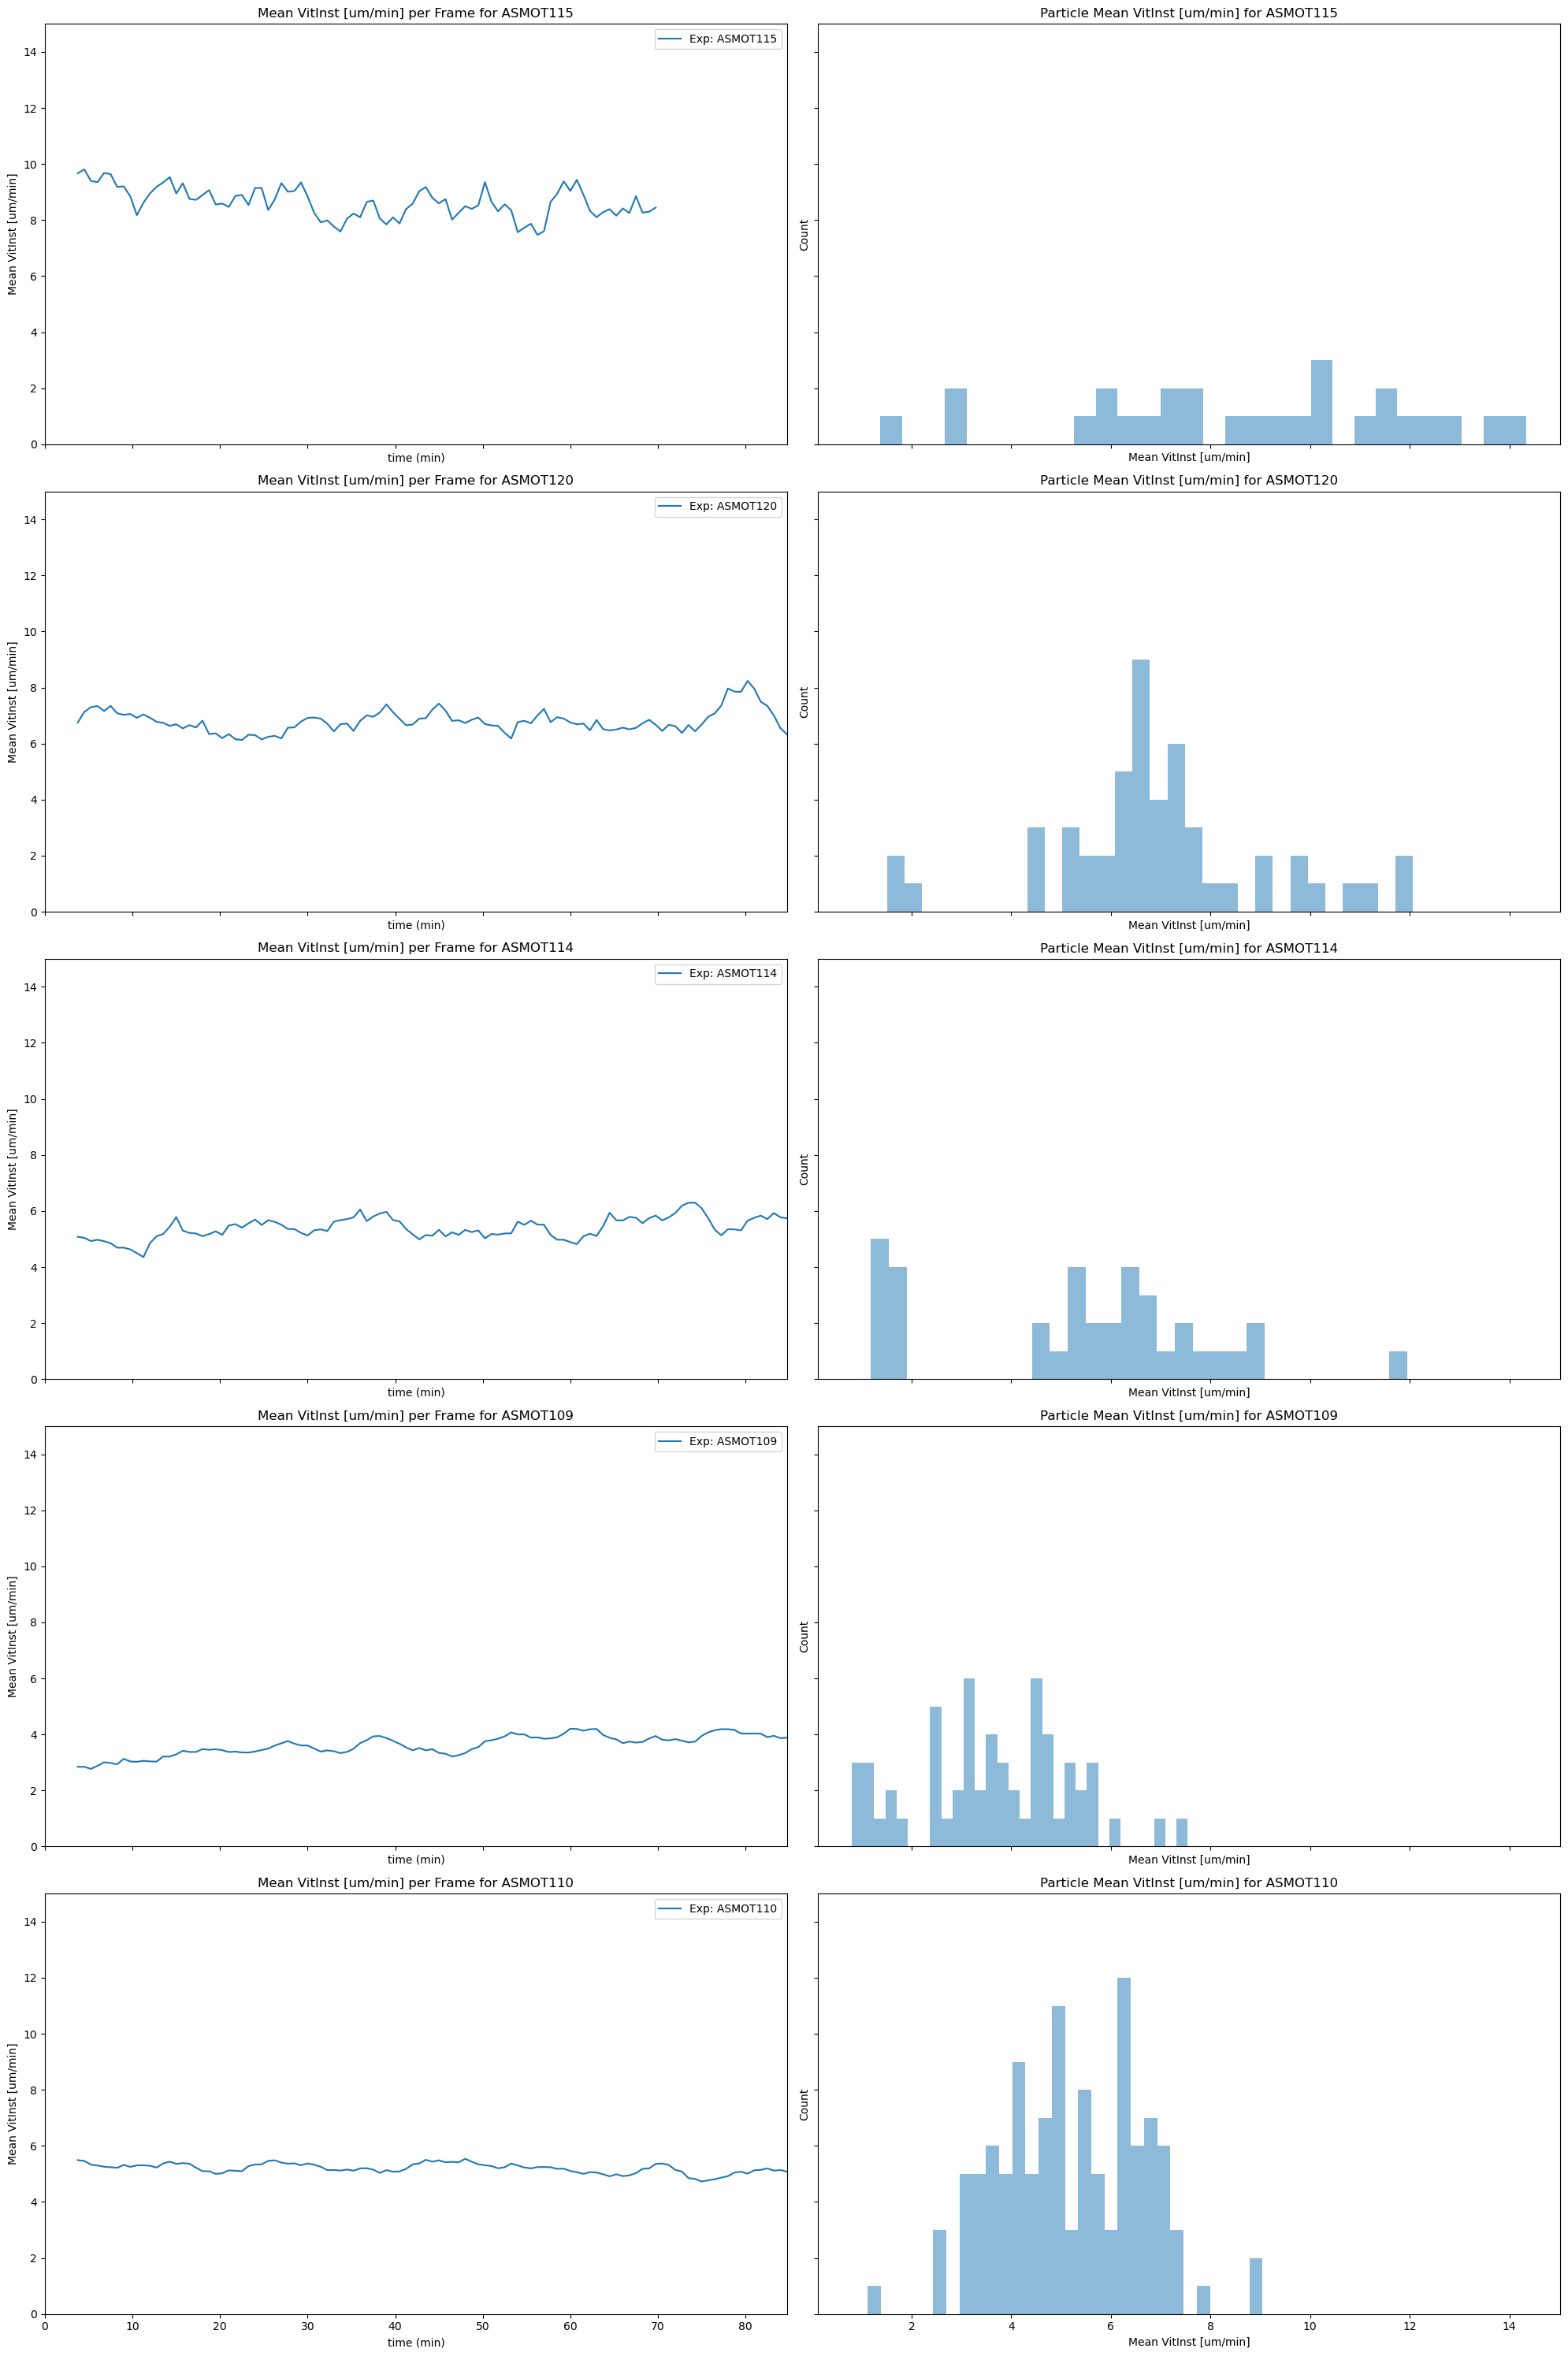

In [920]:
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que DATA est votre DataFrame
experiments = DATA['experiment'].unique()
n_experiments = len(experiments)

# Créer une figure avec deux colonnes de subplots pour chaque expérience
# La première colonne pour la vitesse instantanée moyenne par frame
# La deuxième colonne pour l'histogramme de la vitesse moyenne des particules
fig, axes = plt.subplots(n_experiments, 2, figsize=(20, 6*n_experiments), sharex='col', sharey='row')

# S'assurer que axes est toujours un array 2D pour faciliter l'itération
if n_experiments == 1:
    axes = np.expand_dims(axes, 0)

for i, exp in enumerate(experiments):
    # Filtrer les données pour l'expérience courante
    data_exp = DATA[DATA['experiment'] == exp]
    
    # Premier subplot : vitesse instantanée moyenne par frame
    mean_VitInst_per_frame_i = data_exp.groupby('time (min)')['VitInst [um/min]'].mean()
    mean_VitInst_per_frame_i.index = mean_VitInst_per_frame_i.index
    mean_VitInst_per_frame_smoothed_i = mean_VitInst_per_frame_i.rolling(5).mean().dropna()
    axes[i, 0].plot(mean_VitInst_per_frame_smoothed_i.index, mean_VitInst_per_frame_smoothed_i.values, label=f'Exp: {exp}')
    axes[i, 0].set_title(f'Mean VitInst [um/min] per Frame for {exp}')
    axes[i, 0].set_xlabel('time (min)')
    axes[i, 0].set_ylabel('Mean VitInst [um/min]')
    axes[i, 0].set_xlim([0, max(mean_VitInst_per_frame_i.index)])  # Ajustez selon vos données
    axes[i, 0].set_ylim([0, 15])   # Ajustez selon vos données
    axes[i, 0].legend()

    # Deuxième subplot : histogramme de la vitesse moyenne des particules pour l'expérience
    mean_VitInst_per_particle_i = data_exp.groupby('particle')['VitInst [um/min]'].mean()
    axes[i, 1].hist(mean_VitInst_per_particle_i, bins=30, alpha=0.5)
    axes[i, 1].set_title(f'Particle Mean VitInst [um/min] for {exp}')
    axes[i, 1].set_xlabel('Mean VitInst [um/min]')
    axes[i, 1].set_ylabel('Count')

# Ajuster automatiquement l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()

# Afficher la figure
plt.show()

# Si vous souhaitez sauvegarder la figure entière
# plt.savefig(f"{path_save_pic}/combined_mean_vitinst_per_experiment.jpg", format="jpg")


/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_55089/3141381612.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10', nombre_experiences)  # 'tab10' est une palette de 10 couleurs


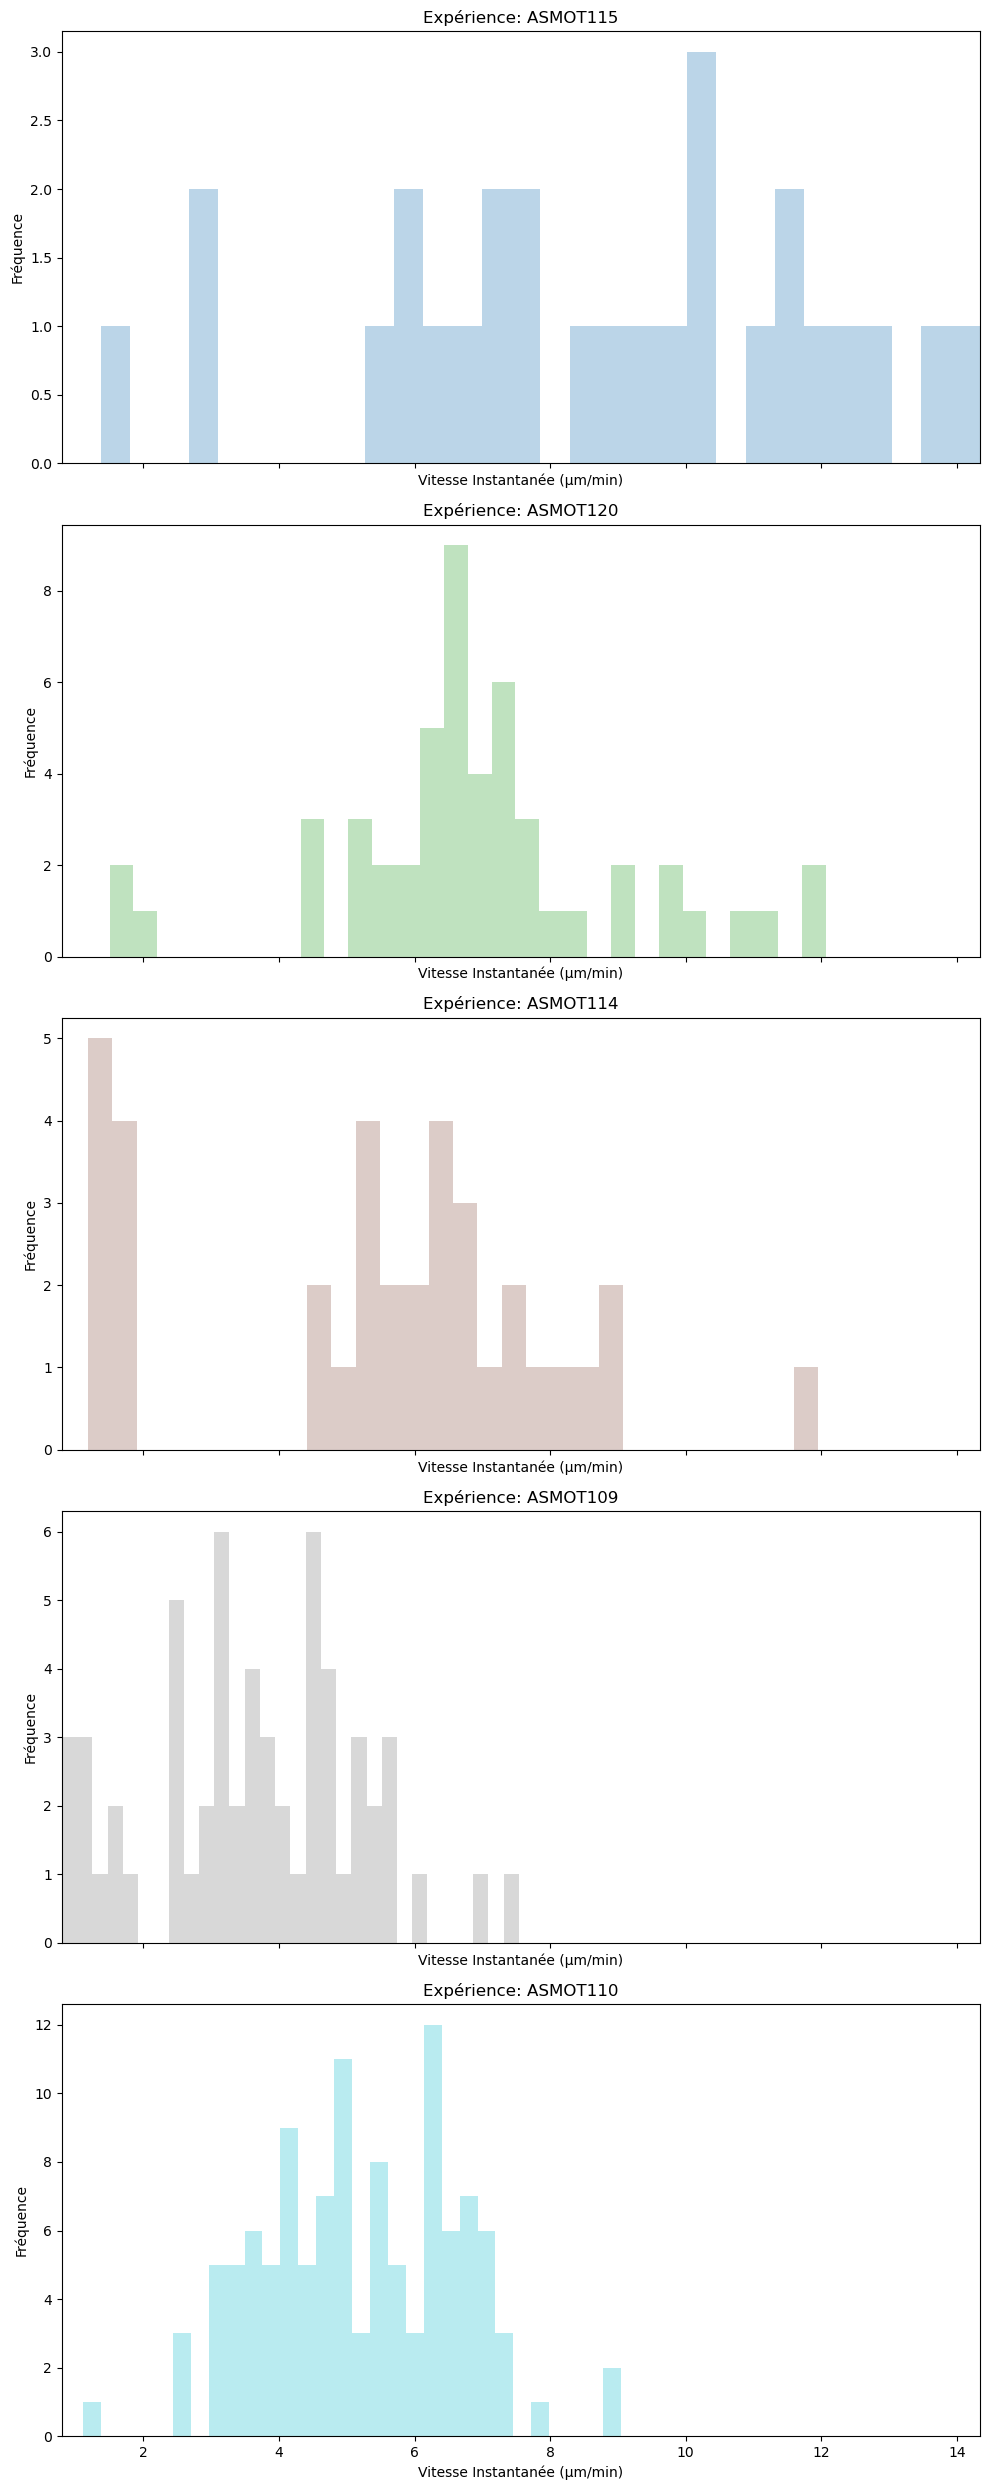

In [921]:
import matplotlib.pyplot as plt
import numpy as np

# Supposons que DATA est un DataFrame Pandas avec vos données
experiences_uniques = DATA['experiment'].unique()
nombre_experiences = len(experiences_uniques)

# Créer une grille de subplots avec un nombre approprié de lignes
fig, axs = plt.subplots(nombre_experiences, 1, figsize=(10, 5 * nombre_experiences), sharex=True)

# Générer une palette de couleurs
palette = plt.cm.get_cmap('tab10', nombre_experiences)  # 'tab10' est une palette de 10 couleurs

# Définir les limites de l'axe des x basées sur les données globales
x_min = DATA.groupby('particle')['VitInst [um/min]'].mean().min()
x_max = DATA.groupby('particle')['VitInst [um/min]'].mean().max()

# Assurez-vous que axs est un array, même s'il n'y a qu'un seul subplot
if nombre_experiences == 1:
    axs = [axs]

# Remplir chaque subplot
for idx, exp in enumerate(experiences_uniques):
    # Calculer la moyenne de la vitesse instantanée pour chaque particule
    moyennes_vitesses = DATA[DATA['experiment'] == exp].groupby('particle')['VitInst [um/min]'].mean()
    
    # Créer un histogramme sur le subplot correspondant avec une couleur unique
    axs[idx].hist(moyennes_vitesses, bins=30, alpha=0.3, color=palette(idx))
    axs[idx].set_title(f'Expérience: {exp}')
    axs[idx].set_xlabel('Vitesse Instantanée (µm/min)')
    axs[idx].set_ylabel('Fréquence')
    axs[idx].set_xlim([x_min, x_max])  # Appliquer la même échelle des x à tous les subplots

# Ajuster l'espace entre les subplots pour éviter le chevauchement
plt.tight_layout()
plt.show()


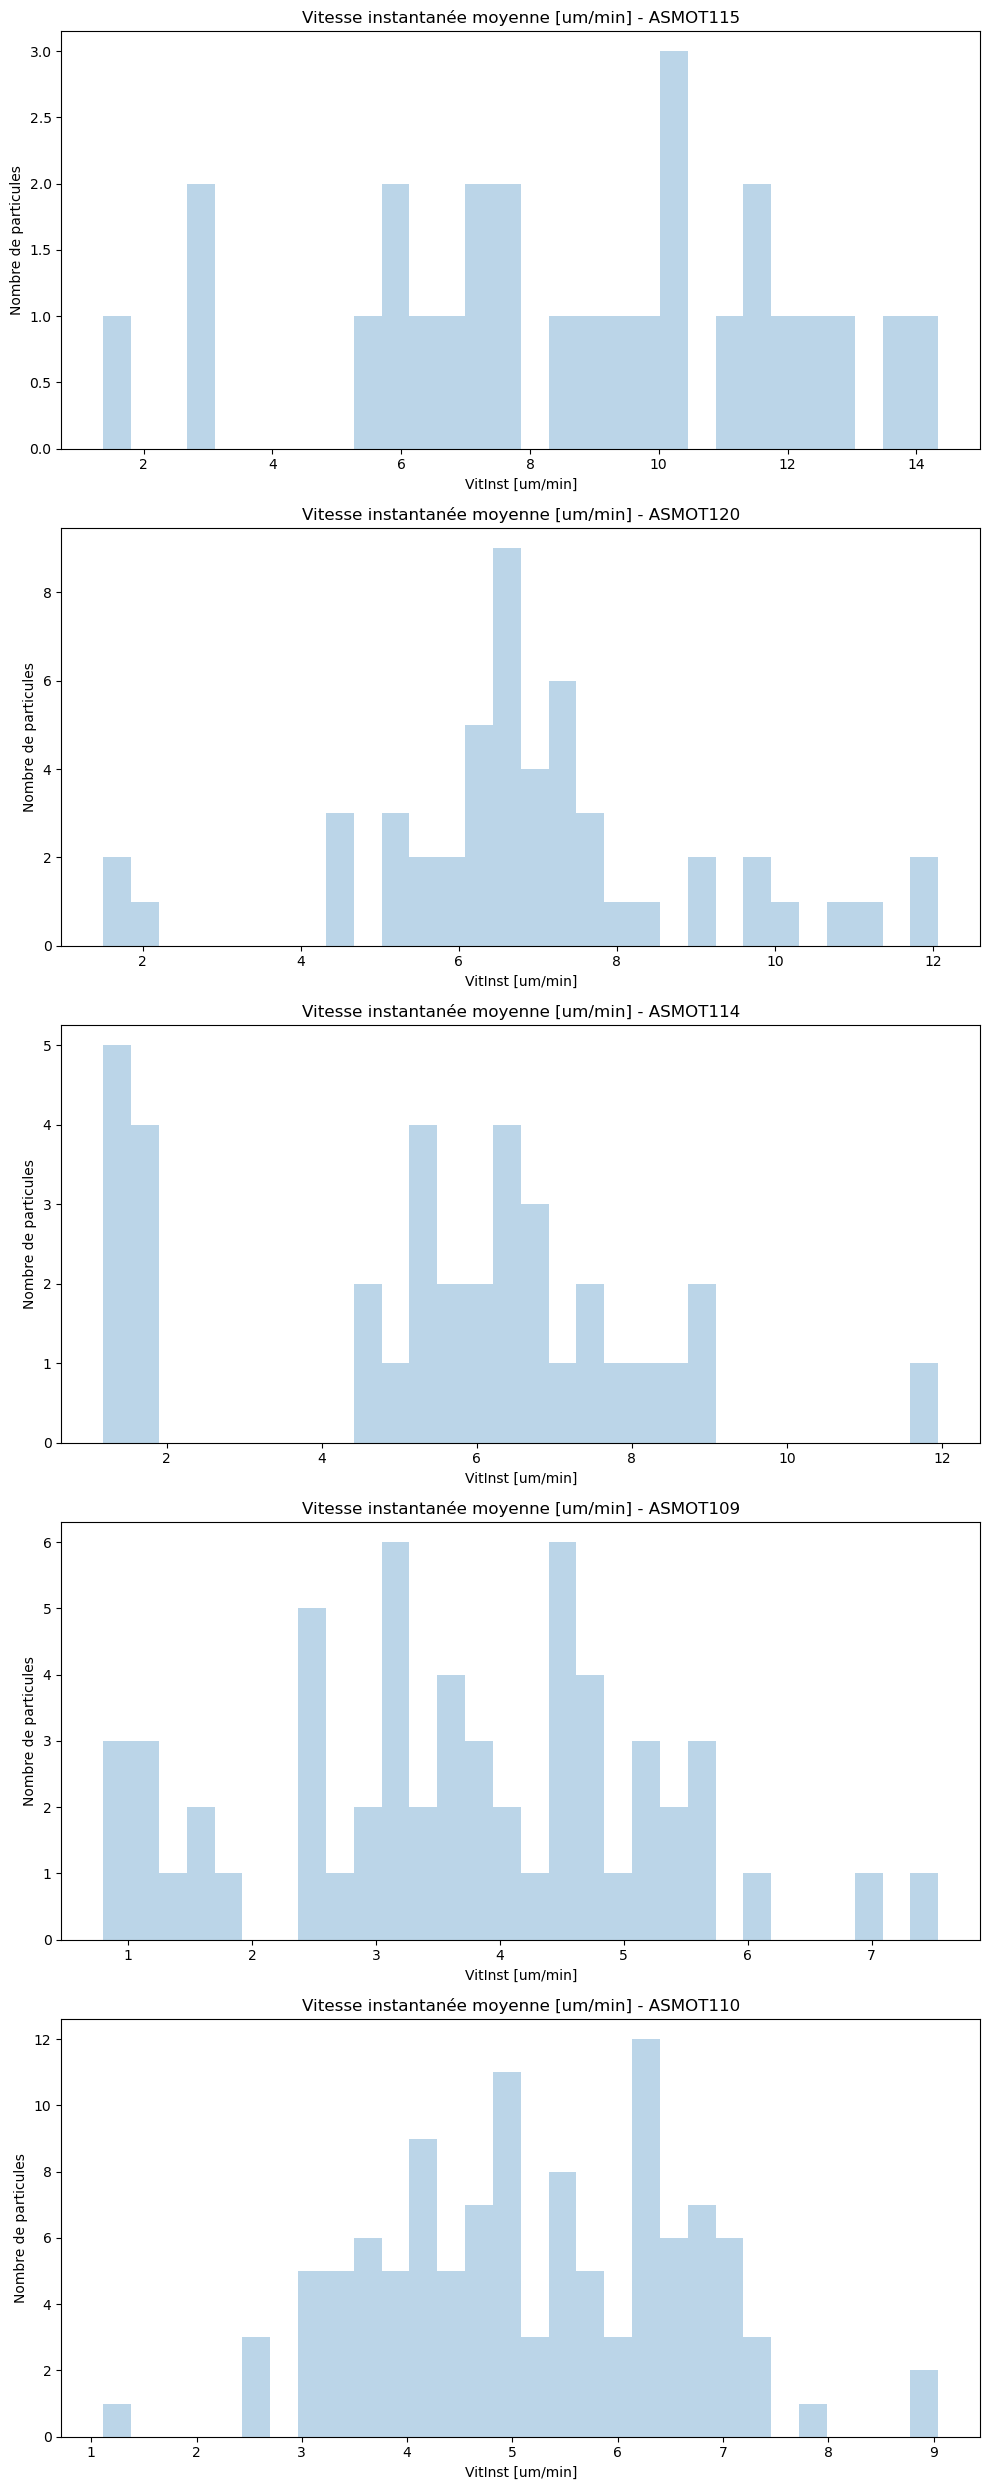

In [922]:
import matplotlib.pyplot as plt

# Obtenir la liste unique des expériences
experiments = DATA['experiment'].unique()
n_experiments = len(experiments)

# Créer une figure et un ensemble de subplots
# Ajustez nrows et ncols selon le nombre d'experiences que vous avez
fig, axes = plt.subplots(nrows=n_experiments, ncols=1, figsize=(10, 5*n_experiments))

# S'assurer que 'axes' est un array pour faciliter l'itération, même s'il n'y a qu'une seule expérience
if n_experiments == 1:
    axes = [axes]

for ax, exp in zip(axes, experiments):
    # Sélectionner les données pour l'expérience courante
    data_exp = DATA[DATA['experiment'] == exp]
    
    # Calculer la vitesse instantanée moyenne pour chaque particule
    mean_vitinst_per_particle = data_exp.groupby('particle')['VitInst [um/min]'].mean()
    
    # Tracer l'histogramme sur le subplot correspondant
    ax.hist(mean_vitinst_per_particle, bins=30, alpha=0.3)
    ax.set_title(f'Vitesse instantanée moyenne [um/min] - {exp}')
    ax.set_xlabel('VitInst [um/min]')
    ax.set_ylabel('Nombre de particules')

# Ajuster l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()

# Afficher la figure
plt.show()


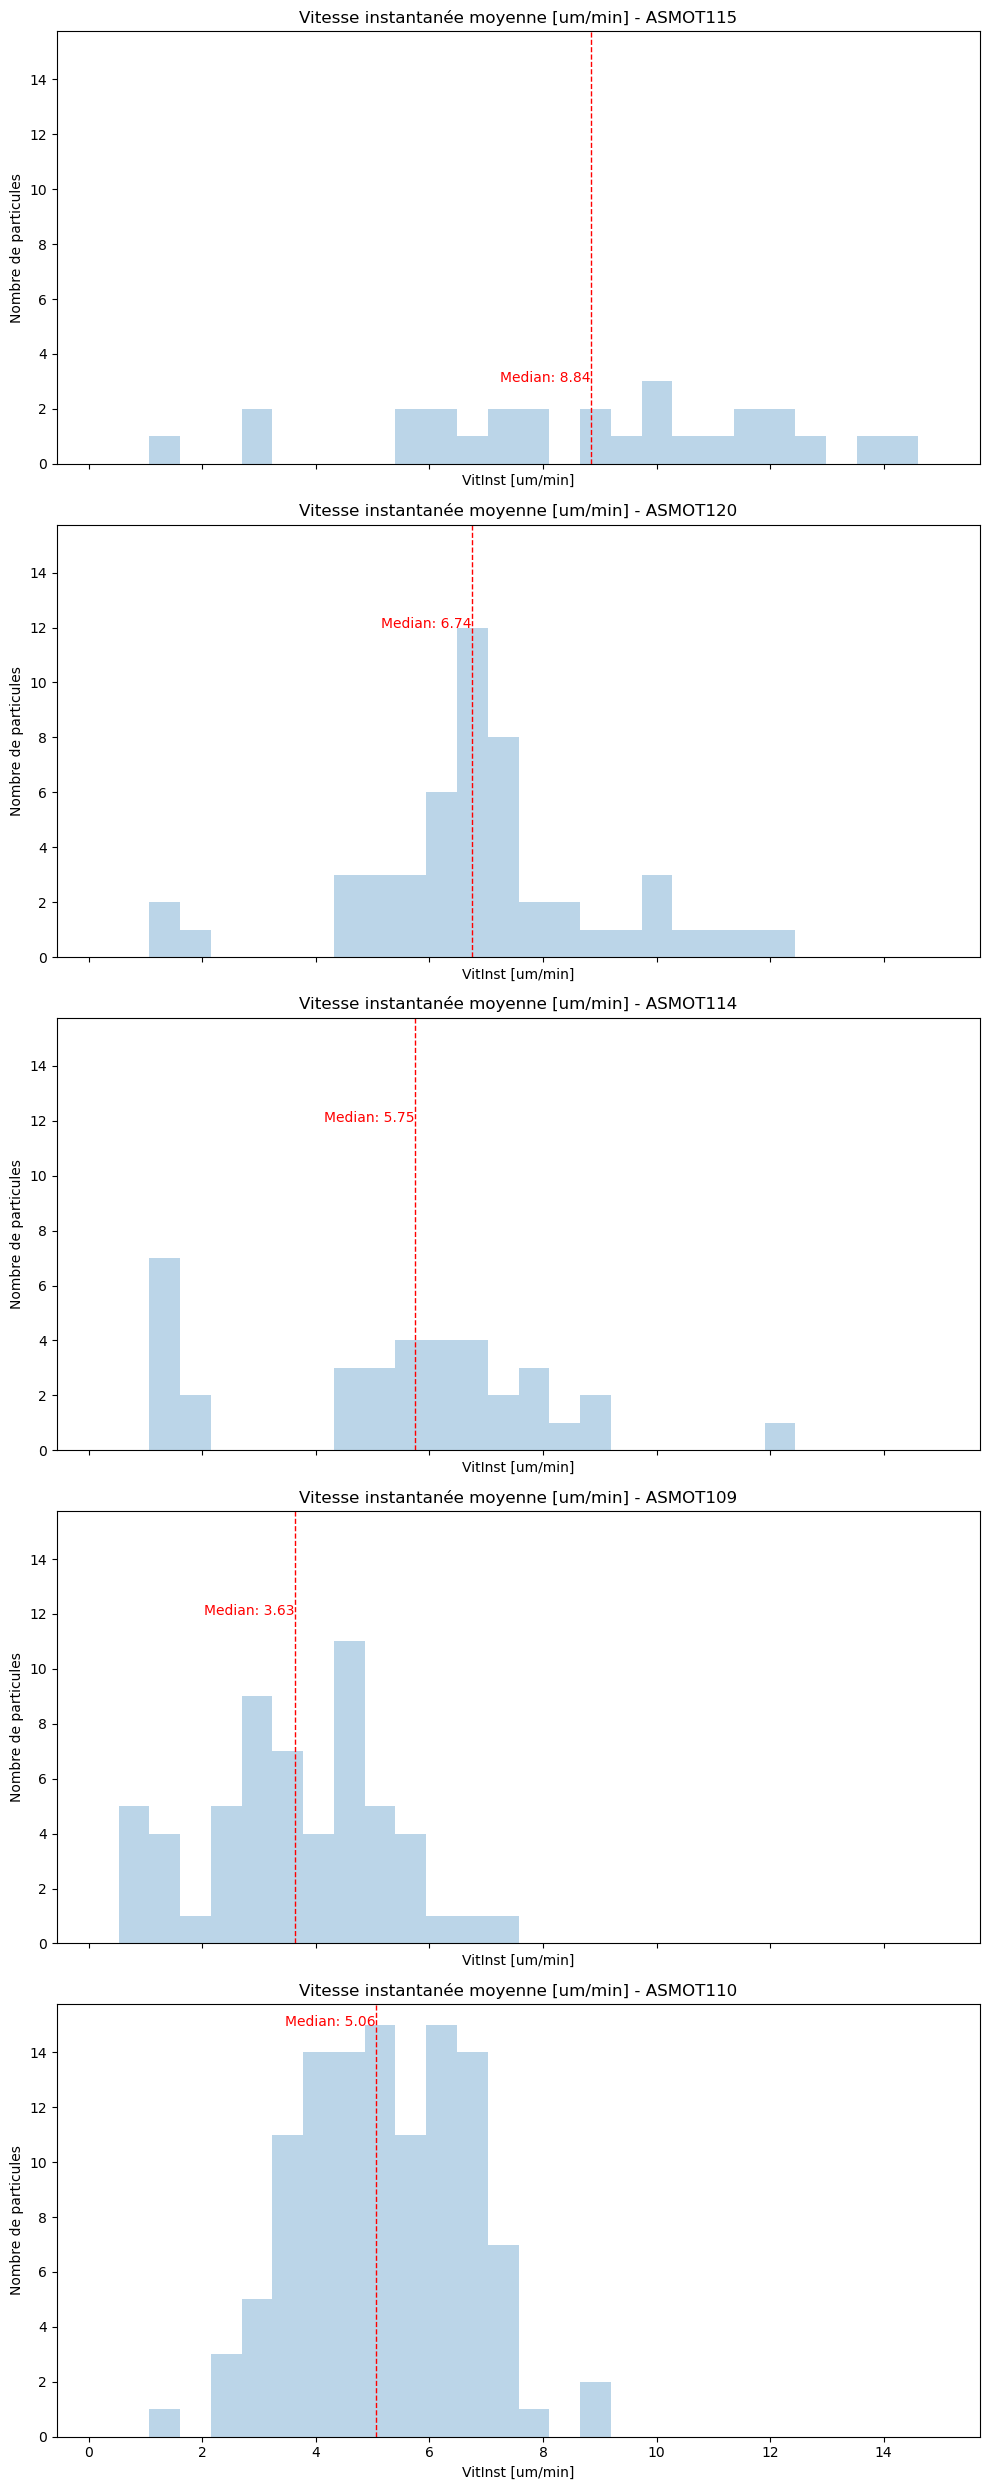

In [923]:
import matplotlib.pyplot as plt

# Calculer les limites globales pour la vitesse instantanée moyenne
all_mean_vitinst = DATA.groupby(['experiment', 'particle'])['VitInst [um/min]'].mean()
global_min, global_max = all_mean_vitinst.min(), all_mean_vitinst.max()

# Ajuster légèrement les limites pour une meilleure visualisation
global_min, global_max = global_min - (global_max - global_min) * 0.1, global_max + (global_max - global_min) * 0.1

# Obtenir la liste unique des expériences
experiments = DATA['experiment'].unique()
n_experiments = len(experiments)

# Créer une figure et un ensemble de subplots
fig, axes = plt.subplots(nrows=n_experiments, ncols=1, figsize=(10, 5*n_experiments), sharex=True, sharey=True)

# S'assurer que 'axes' est un array pour faciliter l'itération, même s'il n'y a qu'une seule expérience
if n_experiments == 1:
    axes = [axes]

for ax, exp in zip(axes, experiments):
    # Sélectionner les données pour l'expérience courante
    data_exp = DATA[DATA['experiment'] == exp]
    
    # Calculer la vitesse instantanée moyenne pour chaque particule
    mean_vitinst_per_particle = data_exp.groupby('particle')['VitInst [um/min]'].mean()
    
    # Tracer l'histogramme sur le subplot correspondant
    ax.hist(mean_vitinst_per_particle, bins=30, alpha=0.3, range=(global_min, global_max))
    ax.set_title(f'Vitesse instantanée moyenne [um/min] - {exp}')
    ax.set_xlabel('VitInst [um/min]')
    ax.set_ylabel('Nombre de particules')
    
    # Calculer et tracer la médiane en rouge
    median_value = mean_vitinst_per_particle.median()
    ax.axvline(median_value, color='red', linestyle='dashed', linewidth=1)
    ax.text(median_value, ax.get_ylim()[1]*0.95, f'Median: {median_value:.2f}', color='red', ha='right')

    # Appliquer les mêmes limites d'axes à tous les subplots
    ax.set_xlim(global_min, global_max)

# Ajuster l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()

# Afficher la figure
plt.show()


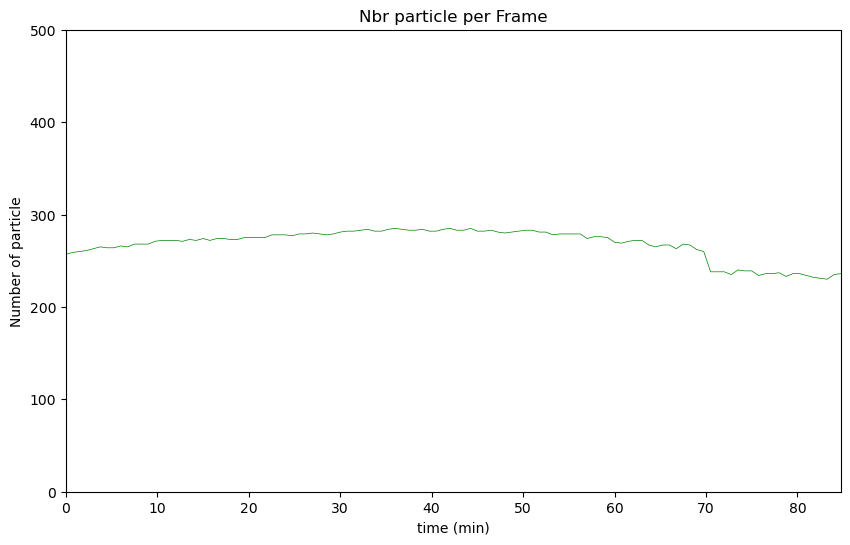

In [924]:
# %% [Number of particle on each frame]

# Grouper les données par 'frame' et calculer la moyenne de 'VitInst [um/min]'
nbr_part_per_frame = DATA.groupby('time (min)')['particle'].nunique()

lib.plot_datas(x_values=nbr_part_per_frame.index, y_values=nbr_part_per_frame.values,
               title='Nbr particle per Frame',
               x_label='time (min)', y_label='Number of particle',
               x_lim=[0, max(nbr_part_per_frame.index)], y_lim=[0, 500], save=True,
               path_save_pic=path_save_pic, img_type="jpg")

In [925]:
import pandas as pd
import numpy as np

# Supposons que df est votre DataFrame contenant les résultats du tracking
# df devrait avoir des colonnes 'particle', 'frame', 'x', et 'y'
df = DATA
# Fonction pour calculer le vecteur de déplacement
def displacement_vectors(df):
    df['dx'] = df.groupby('particle')['x'].diff()
    df['dy'] = df.groupby('particle')['y'].diff()
    return df.dropna()

# Normaliser les vecteurs de déplacement
def normalize_vectors(df):
    df = df.copy()
    magnitude = np.sqrt(df['dx']**2 + df['dy']**2)
    df.loc[:, 'dx_norm'] = df['dx'] / magnitude
    df.loc[:, 'dy_norm'] = df['dy'] / magnitude
    return df

# Calculer l'angle des vecteurs
# Arctan2 permet de calculer l'angle en radians entre la partie positive de l'axe des abscisses d'un plan et le point (x,y)
# Angle positif dans le sens trigo et négativ dans le sens inverse trigo
def calculate_angles(df):
    df = df.copy()
    df.loc[:, 'angle'] = np.arctan2(df['dy_norm'], df['dx_norm'])
    return df

# Calculer l'autocorrélation directionnelle
def direction_autocorrelation(df, max_lag):
    results = []
    for particle in df['particle'].unique():
        particle_df = df[df['particle'] == particle].copy()
        for lag in range(1, max_lag + 1):
            particle_df['angle_lag'] = particle_df['angle'].shift(-lag)
            cos_diff = np.cos(particle_df['angle'] - particle_df['angle_lag'])
            autocorr = cos_diff.mean()
            results.append({'particle': particle, 'lag': lag, 'autocorrelation': autocorr})
    return pd.DataFrame(results).dropna()

# Appliquer les fonctions
df = displacement_vectors(df)
df = normalize_vectors(df)
df = calculate_angles(df)
max_lag = 10  # Ajustez en fonction de la longueur de vos trajectoires
autocorr_df = direction_autocorrelation(df, max_lag)

In [926]:
IMSD = tp.imsd(traj=DATA,
               mpp=SIZE_PIX, fps=FPS,
               max_lagtime=200, statistic='msd',
               pos_columns=None)
IMSD

0           1           2           3         4    \
lag time [s]                                                             
45.0           34.888450   36.311780   14.372914   22.885395  0.768422   
90.0           81.023721   82.627445   38.099201   66.008579  0.795406   
135.0         146.262149  147.827561   64.804987  127.289496  0.643849   
180.0         234.772398  239.161896   92.581948  201.889788  0.785195   
225.0         336.924818  342.160639  121.353709  289.693690  0.974600   
...                  ...         ...         ...         ...       ...   
4905.0               NaN         NaN         NaN         NaN       NaN   
4950.0               NaN         NaN         NaN         NaN       NaN   
4995.0               NaN         NaN         NaN         NaN       NaN   
5040.0               NaN         NaN         NaN         NaN       NaN   
5085.0               NaN         NaN         NaN         NaN       NaN   

                     5         6           7           8           9    ...  \
lag time [s]                                                            ...   
45.0           34.235307  4.325196   17.362740   17.165602   25.621136  ...   
90.0           64.769771  3.841130   51.407482   46.483235   72.281181  ...   
135.0         110.033345  4.005577   94.127153   85.155988  136.997458  ...   
180.0         172.017516  4.170424  143.744848  128.433650  212.042172  ...   
225.0         242.571415  3.825681  200.536220  171.641044  294.452378  ...   
...                  ...       ...         ...         ...         ...  ...   
4905.0               NaN       NaN         NaN         NaN         NaN  ...   
4950.0               NaN       NaN         NaN         NaN         NaN  ...   
4995.0               NaN       NaN         NaN         NaN         NaN  ...   
5040.0               NaN       NaN         NaN         NaN         NaN  ...   
5085.0               NaN       NaN         NaN         NaN         NaN  ...   

                     275         276         277         278         279  \
lag time [s]                                                               
45.0           19.721929   21.621159   30.759692   28.029407   11.960614   
90.0           67.432588   74.081065  107.687728   99.130094   38.438858   
135.0         137.625342  151.631704  226.628421  203.099475   71.567324   
180.0         231.046111  252.831721  377.482288  339.115162  107.840974   
225.0         346.626589  372.255262  551.534044  510.061410  146.543421   
...                  ...         ...         ...         ...         ...   
4905.0               NaN         NaN         NaN         NaN         NaN   
4950.0               NaN         NaN         NaN         NaN         NaN   
4995.0               NaN         NaN         NaN         NaN         NaN   
5040.0               NaN         NaN         NaN         NaN         NaN   
5085.0               NaN         NaN         NaN         NaN         NaN   

                     280         281         282        283        284  
lag time [s]                                                            
45.0           23.583023   20.666061   26.394732   5.348600   5.725304  
90.0           82.976011   70.666190   95.049348  16.313838  17.958924  
135.0         174.404922  139.330894  202.107899  29.357518  33.356314  
180.0         296.594831  226.484899  347.860025  42.412964  48.525542  
225.0         446.624570  327.747116  529.383191  53.692396  61.372756  
...                  ...         ...         ...        ...        ...  
4905.0               NaN         NaN         NaN        NaN        NaN  
4950.0               NaN         NaN         NaN        NaN        NaN  
4995.0               NaN         NaN         NaN        NaN        NaN  
5040.0               NaN         NaN         NaN        NaN        NaN  
5085.0               NaN         NaN         NaN        NaN        NaN  

[113 rows x 285 columns]

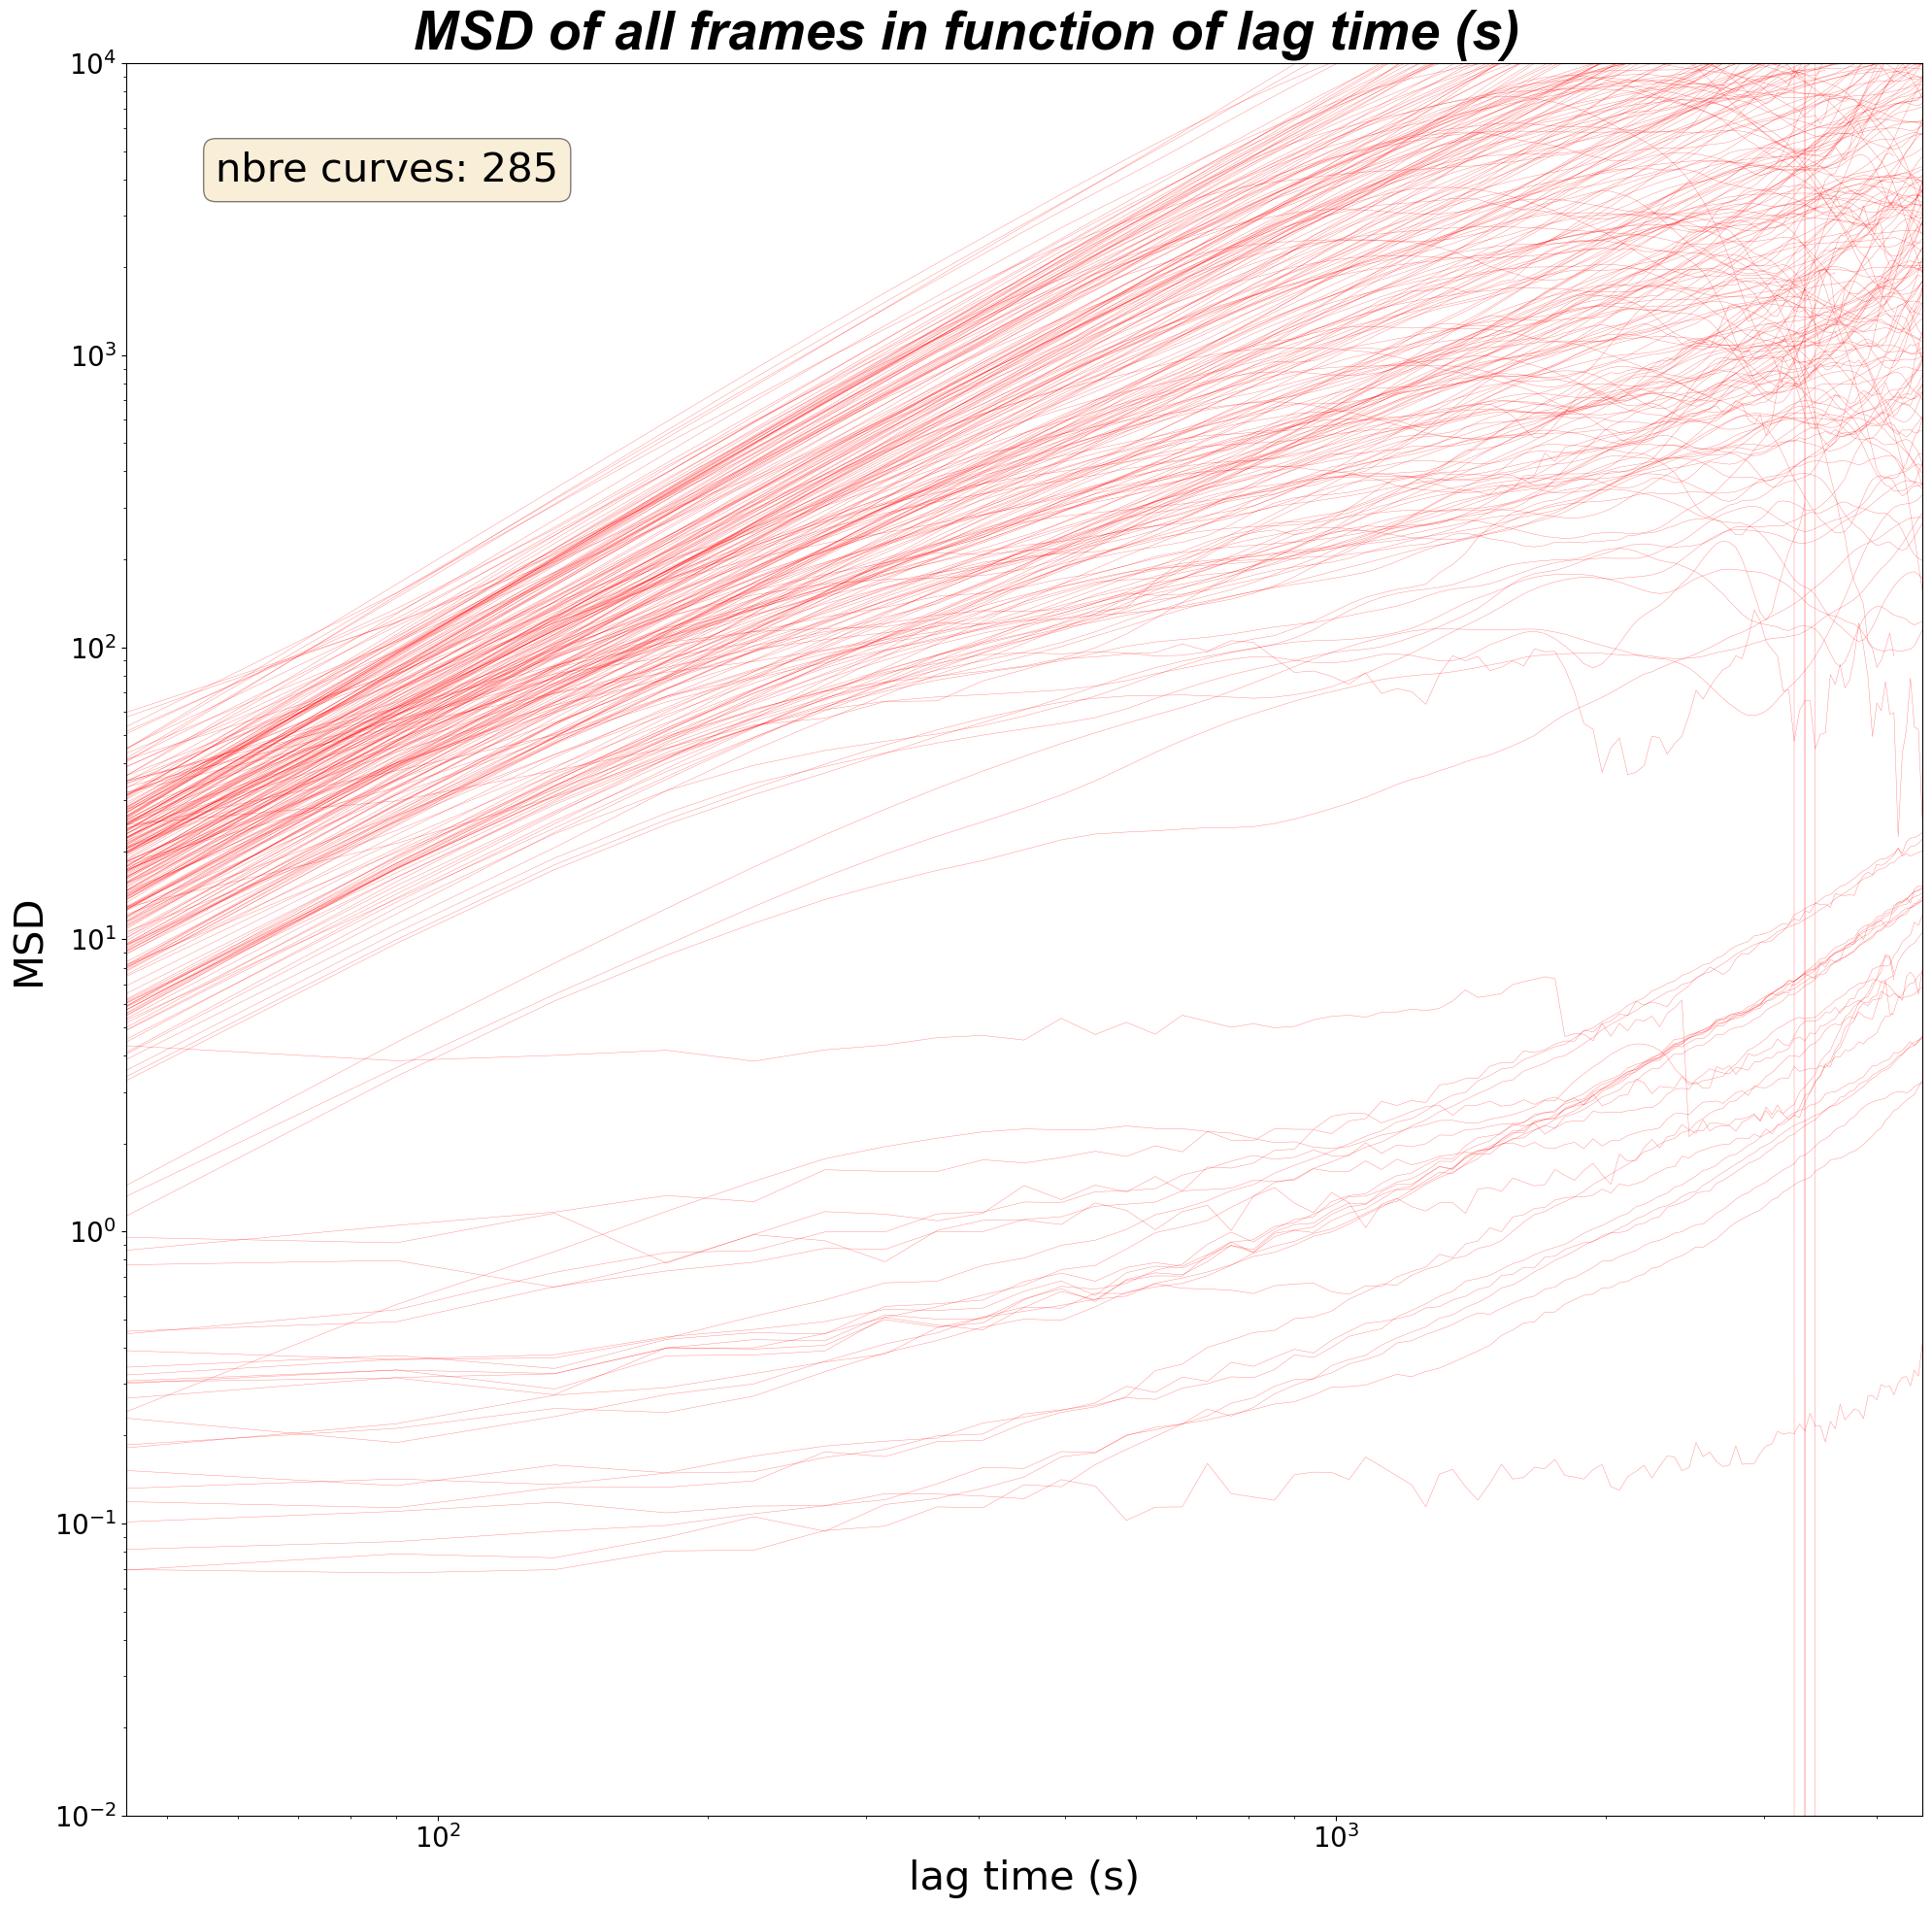

In [927]:
lib.plot_msd(IMSD, fps=FPS, name="MSD of all frames in function of lag time (s)",
             color_plot = 'red', save=False, pathway_saving=None,
             alpha=0.5, linewidth=0.3, img_type='jpg')

# negative slope 2


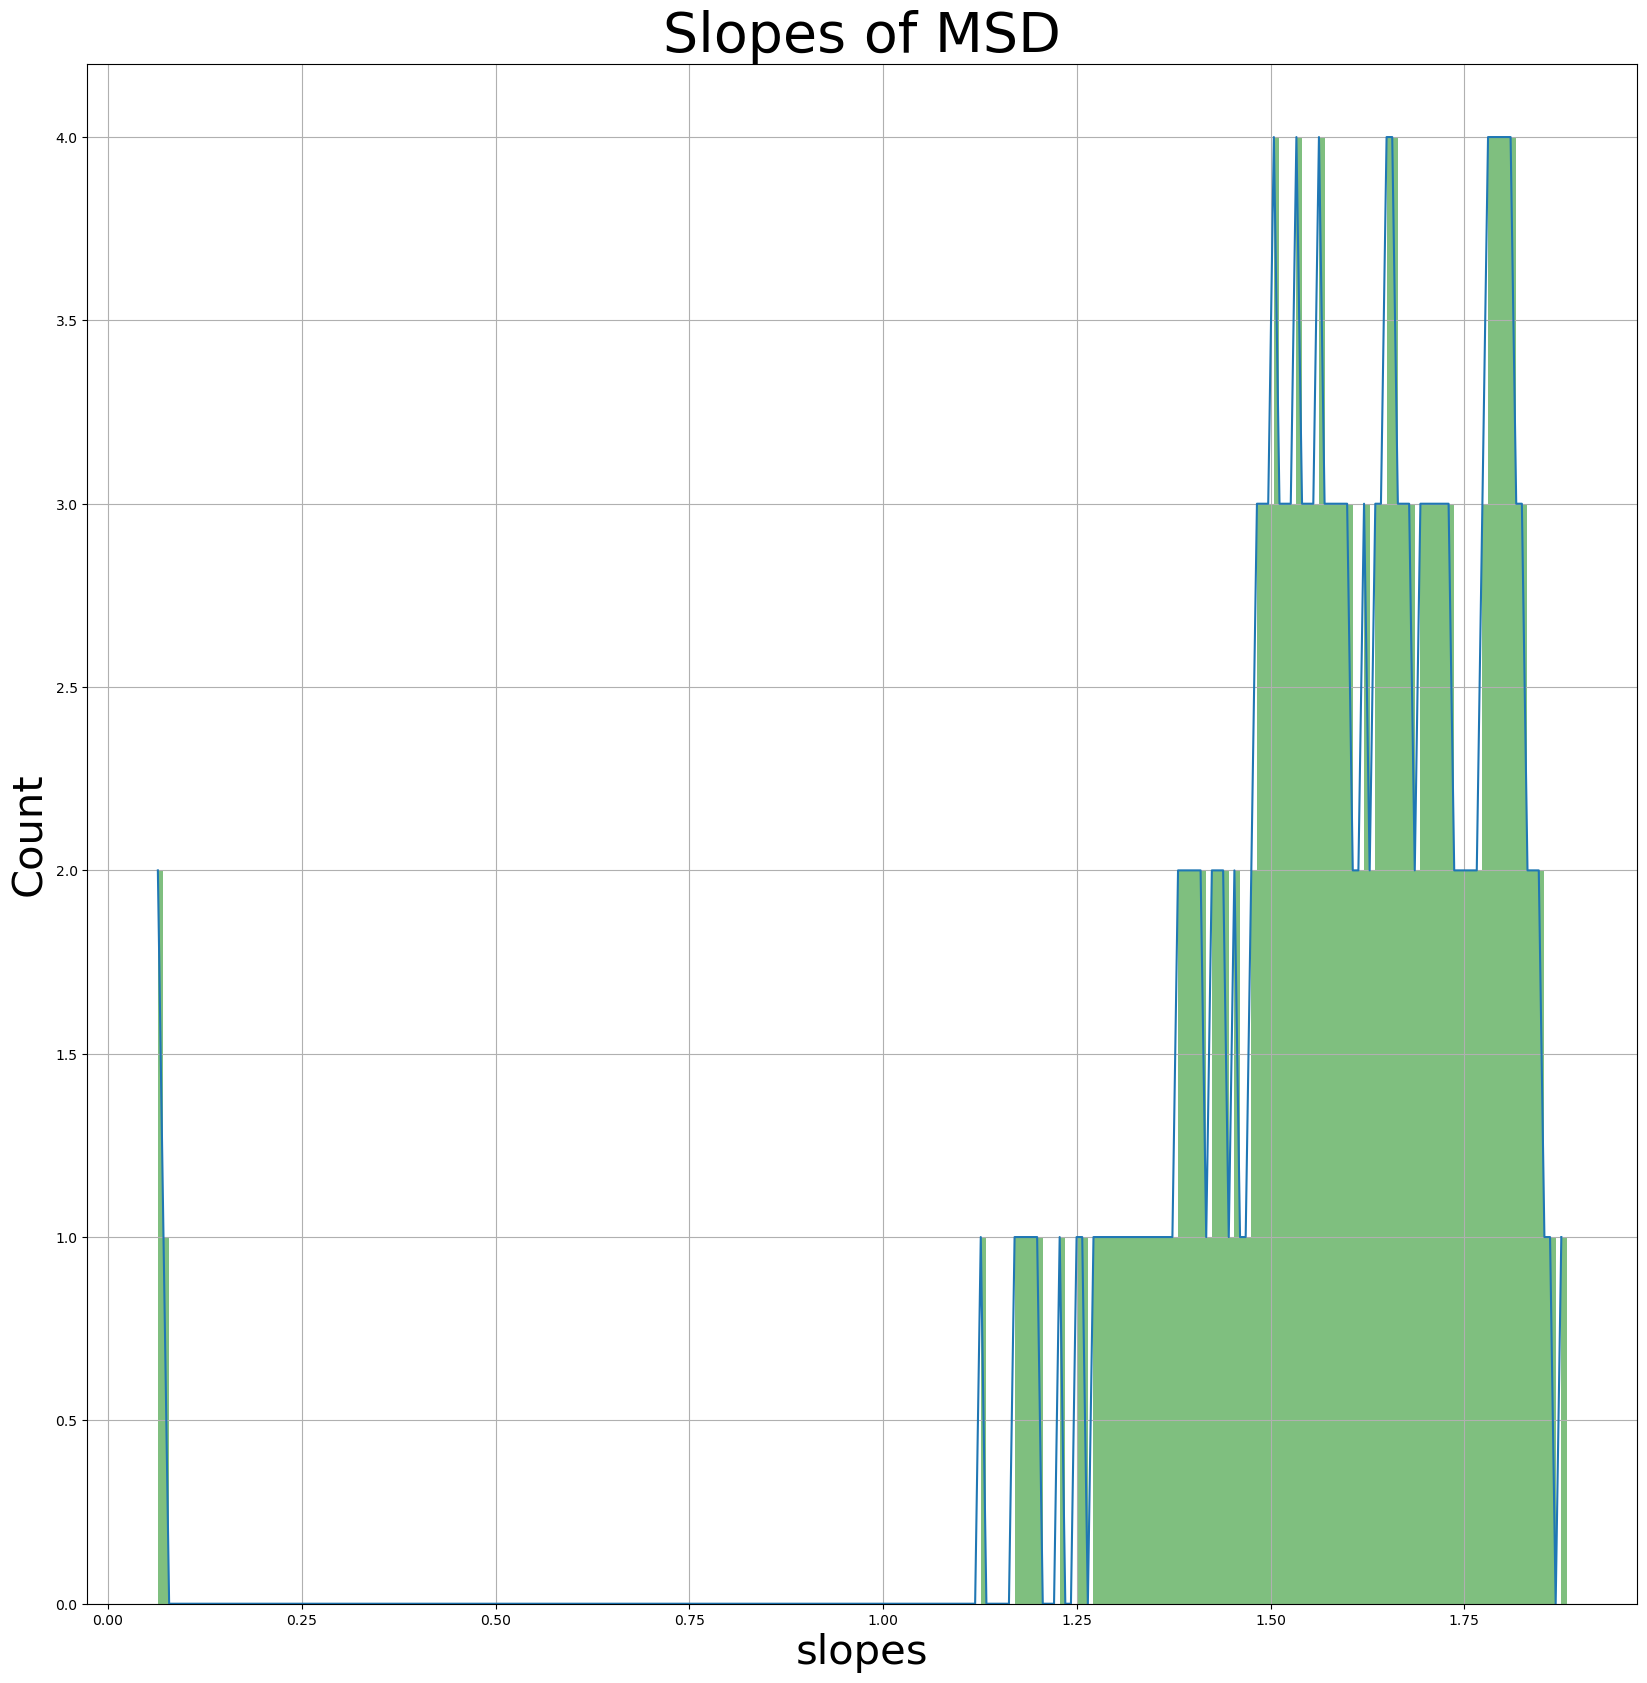

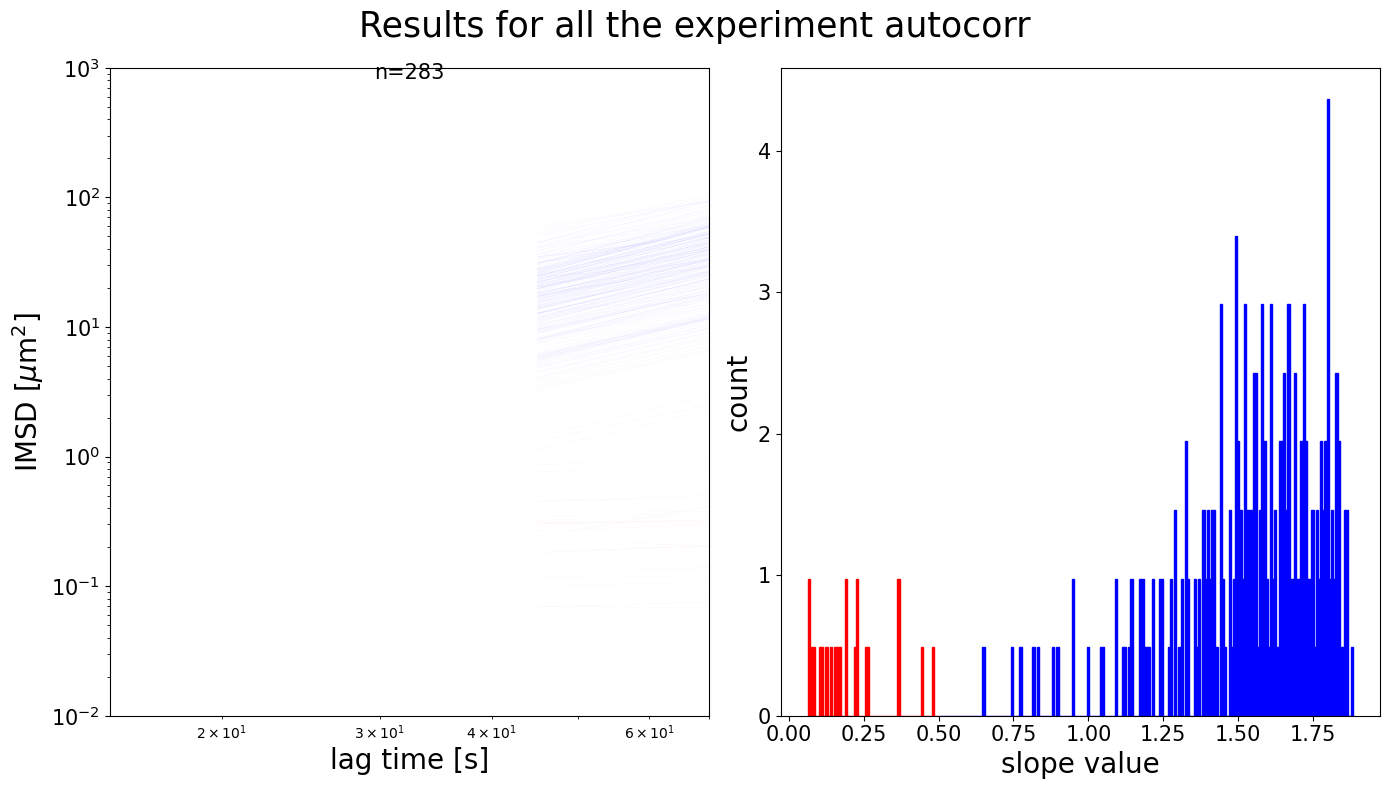

In [928]:
# %% [traj clustering with fit and defining a cutoff]
LAG_TIME_FIT = 5
# Compute et plot the director factor of the imsd
importlib.reload(lib)

COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF =\
    lib.traj_clustering_with_fit_cutoff(DATA, imsd=IMSD, hist=True,
                                        lag_time_fit=LAG_TIME_FIT,
                                        micronperpixel=SIZE_PIX,
                                        fps=FPS, binsize=250,
                                        peak_height=50, peak_width=1,
                                        save=True, pathway_fig=path_save_pic,
                                        name='all the experiment autocorr', img_type="jpg",
                                        plot=True, color_sup_inf=color_sup_inf,
                                        cutoff_default=0.5
                                        )

# # DATA_INF, DATA_SUP, IMSD_INF, IMSD_SUP,
# DATA_INF = DATA[DATA['particle'].isin(PART_COEF_INF)]
# DATA_SUP = DATA[DATA['particle'].isin(PART_COEF_SUP)]
# IMSD_INF = IMSD.loc[:, IMSD.columns.isin(PART_COEF_INF)]
# IMSD_SUP = IMSD.loc[:, IMSD.columns.isin(PART_COEF_SUP)]

In [929]:
# for numero_particule in df_negative['particle'].unique():
#     print(numero_particule)
#     print("Etude de la particule : ", numero_particule, ' dans la manip', DATA[DATA['particle']==numero_particule]['experiment'].iloc[0])
#     lib.create_cropped_tracking_gif(datas=DATA, target_particle = numero_particule,
#                                     condition = CONDITION_simple,
#                                     dot_size= 7,
#                                     crop_size=100, 
#                                     gif=False,
#                                     pathway_saving=None,
                                    # pathway_initial='/Volumes/Labo_Alex_Mac/A_analyser/')

In [930]:
# Assurez-vous que sums_df est un DataFrame Pandas
sums_df = pd.DataFrame(columns=['experiment', 'particle', 'displacement_sum'])

rows = []

for exp in DATA['experiment'].unique():
    exp_data = DATA[DATA['experiment'] == exp]
    for particle_id, part in exp_data.groupby('particle'):
        displacement_sum = part['displacement [pix]'].head(200).sum()
        new_row = {'experiment': exp, 'particle': particle_id, 'displacement_sum': displacement_sum}
        rows.append(new_row)

# Création d'un nouveau DataFrame à partir de la liste de dictionnaires
sums_df = pd.DataFrame(rows)


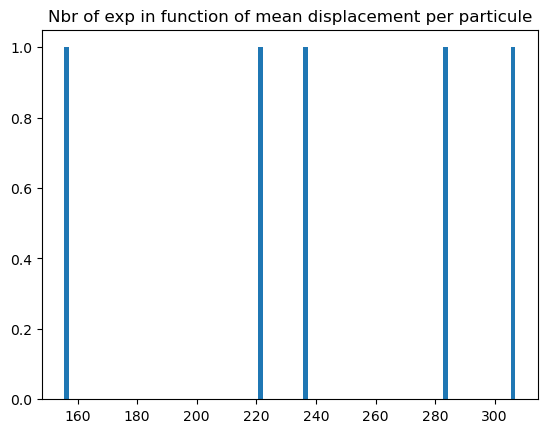

In [931]:
mean_sum = []
for _, exp in sums_df.groupby('experiment'):
    mean_sum.append(exp['displacement_sum'].mean())

plt.hist(mean_sum, bins = 100)
plt.title("Nbr of exp in function of mean displacement per particule")
plt.savefig(path_save_pic + f"Nbr of exp in function of mean displacement per particule {CONDITION_simple}.png", format='png') 
plt.show()

In [932]:
# Y'a t'il l'air d'enregistrer? 
# size en fonction ? 
# faire des manip en x10
# calculer un pseudo packing fraction : nombre de cellule par unité d'air. Ensuite, on essaye de voir la size des cells. 
# Cela dit, c'est vraiment le nombre de cellules par unité d'aire qui m'interesse

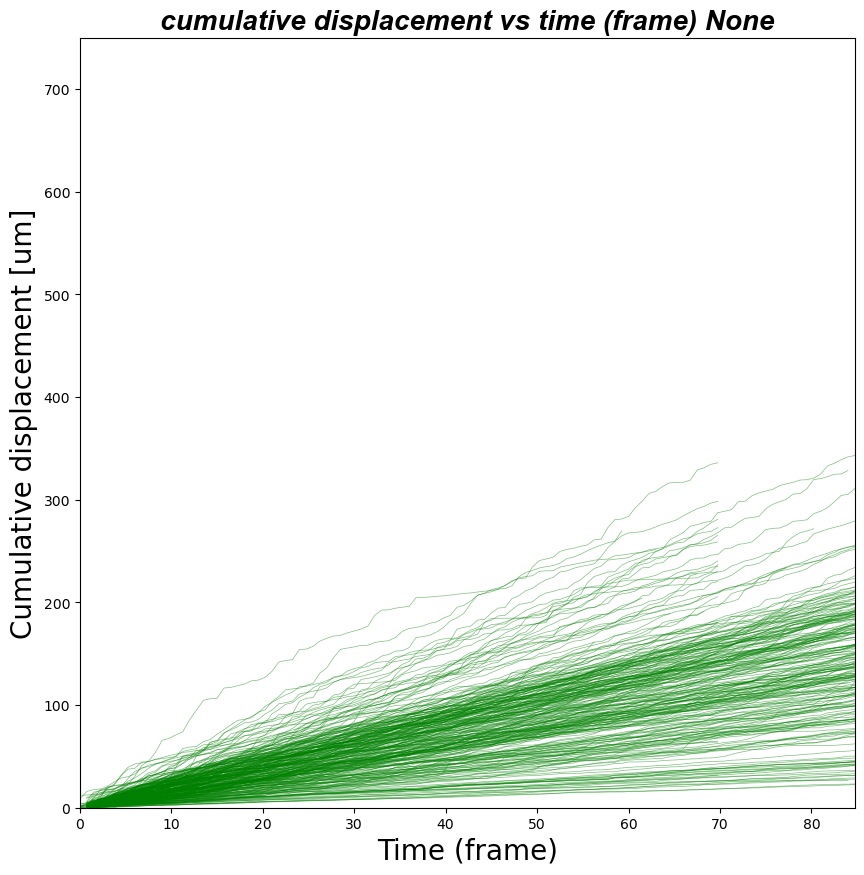

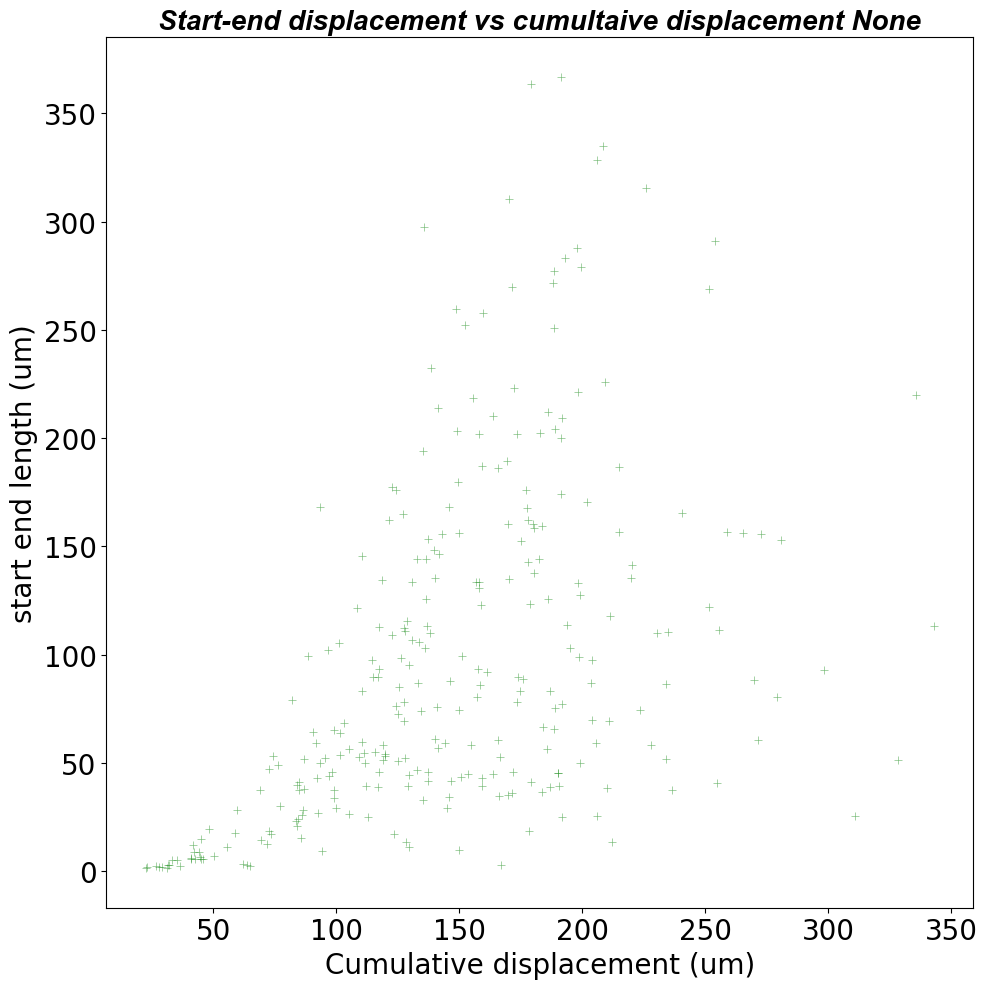

In [933]:
importlib.reload(lib)
lib.plot_displacement(DATA, start_end=start_end, alpha = 0.5, linewidth=0.5, ylim=[0, 750], xlim=[0, max(DATA['time (min)'])])
plt.show()

(0.0, 400.0)

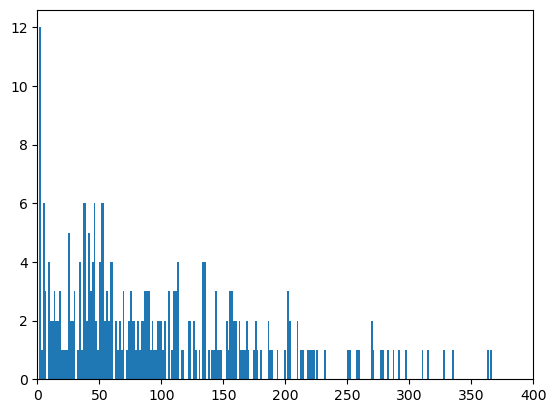

In [934]:
plt.hist(start_end, bins=250)
plt.xlim([0,400])

In [935]:
cumulative = DATA.groupby('particle')['cumulative displacement [um]'].last()
cumulative_filtered = cumulative[cumulative > 200]
filtered_DATA = DATA[DATA['particle'].isin(cumulative_filtered.index)]
for i in filtered_DATA['particle'].unique():
    print(filtered_DATA[filtered_DATA['particle']==i].iloc[0])

index                                                                           0
y                                                                     5758.592806
x                                                                     4232.189285
mass                                                                    8005.4476
size                                                                    13.870742
ecc                                                                      0.239629
signal                                                                  33.013871
raw_mass                                                                 301672.0
ep                                                                       0.521247
frame                                                                           0
old_particle                                                                    1
count                                                                         280
particle        

In [936]:
for exp in DATA['experiment'].unique():
    # Calculer ymax et xmax pour chaque expérience
    ymax = math.ceil(DATA[DATA['experiment'] == exp]['y'].max() / 2048)
    xmax = math.ceil(DATA[DATA['experiment'] == exp]['x'].max() / 2048)

    # Convertir en int si nécessaire (math.ceil retourne déjà un int)
    ymax = int(ymax)
    xmax = int(xmax)
    # Filtrer le DataFrame pour l'expérience et les 200 premières frames
    exp_data = DATA[(DATA['experiment'] == exp) & (DATA['frame'] < 340)]
    nbr_particles = exp_data['particle'].nunique()
 
    # # Grouper par 'frame' et compter les particules
    # particules_par_frame = exp_data.groupby('frame')['particle'].nunique()

    # # Calculer la moyenne du nombre de particules
    # moyenne_particules = particules_par_frame.mean()
    # nombre_part_par_champs = moyenne_particules/(xmax*ymax)
    nombre_part_par_champs = nbr_particles/(xmax*ymax)
    print(f"Nombre de cellules par champs pour la manips {exp}:", nombre_part_par_champs)

Nombre de cellules par champs pour la manips ASMOT115: 1.8
Nombre de cellules par champs pour la manips ASMOT120: 3.4
Nombre de cellules par champs pour la manips ASMOT114: 2.4
Nombre de cellules par champs pour la manips ASMOT109: 2.9
Nombre de cellules par champs pour la manips ASMOT110: 5.65


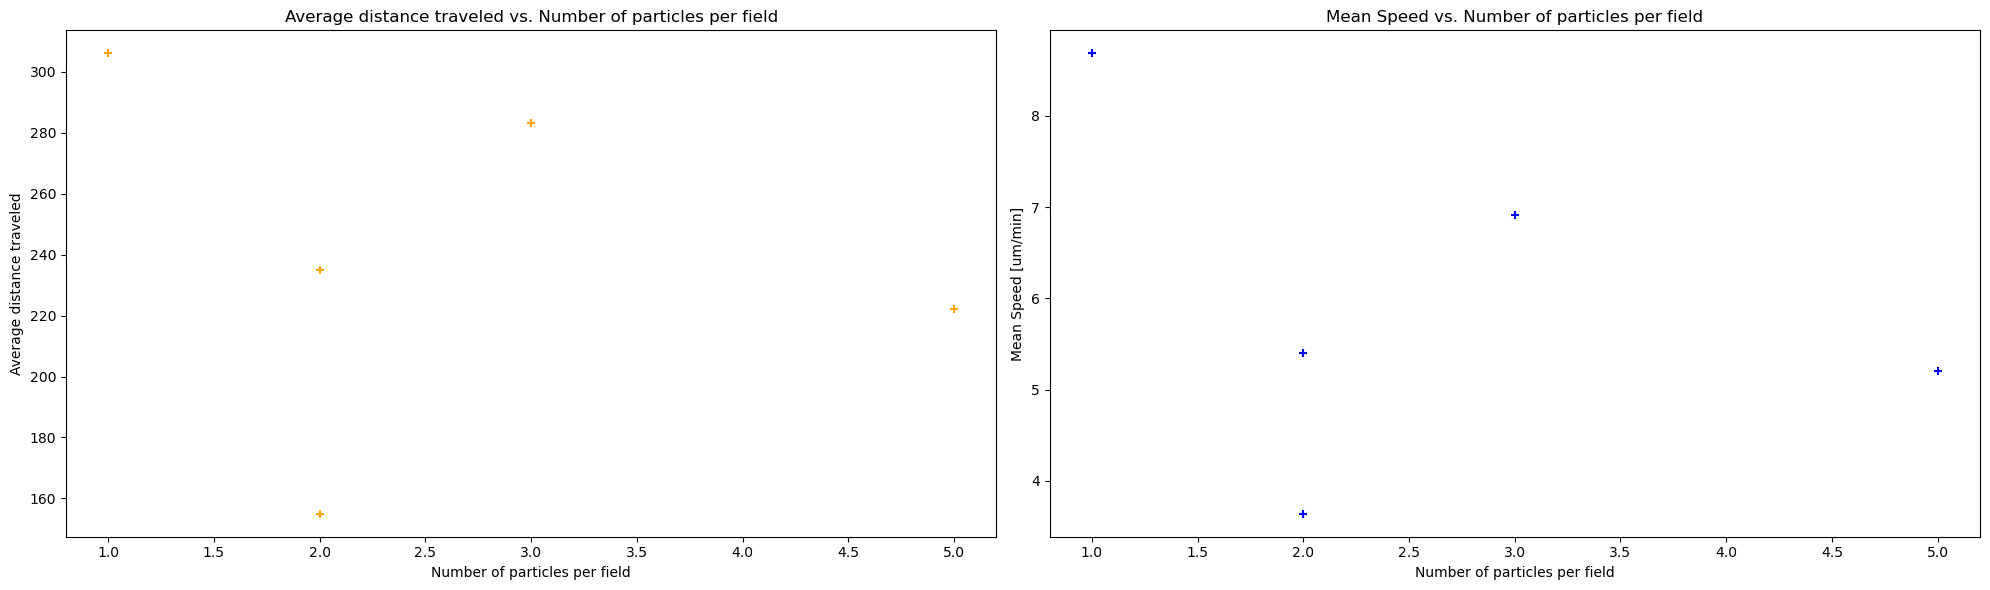

In [950]:
import matplotlib.pyplot as plt

# Supposons que result_df est votre DataFrame contenant les données nécessaires

# Création d'une grille de sous-graphiques 2x2
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # Ajustez la taille selon vos besoins

# Aplatir le tableau d'axes pour un accès plus facile
ax1, ax2, = axes.flatten()

# Premier graphique: Mean Sum vs. Nombre de Particules par Champ
ax1.scatter(result_df['nombre_part_par_champs'], result_df['mean_sum'], marker='+', color='orange')
ax1.set_title('Average distance traveled vs. Number of particles per field')
ax1.set_xlabel('Number of particles per field')
ax1.set_ylabel('Average distance traveled')

# Deuxième graphique: Mean Speed vs. Nombre de Particules par Champ
ax2.scatter(result_df['nombre_part_par_champs'], result_df['mean_speed [um/min]'], marker='+', color='blue')
ax2.set_title('Mean Speed vs. Number of particles per field')
ax2.set_xlabel('Number of particles per field')
ax2.set_ylabel('Mean Speed [um/min]')

# # Masquer le quatrième axe car il n'est pas utilisé
# ax4.axis('off')

# Ajustement de la mise en page pour éviter le chevauchement des titres
plt.tight_layout()

# Afficher les graphiques
plt.show()

fig.savefig(path_save_pic + f"graph in function of nbr of particles per field {CONDITION_simple}.png", format='png') 

In [937]:
path=filtered_DATA[filtered_DATA['particle']==filtered_DATA['particle'].unique()[0]]['experiment'].iloc[0]
import glob
glob.glob(f'/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x_faits/*{path}*')
path

'ASMOT115'

In [938]:
importlib.reload(lib)
import glob
for i in filtered_DATA['particle'].unique():
    path=filtered_DATA[filtered_DATA['particle']==i]['experiment'].iloc[0]
    path_frames = glob.glob(f'/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x/faits/*{path}*')[0]
    print('path frames' , path_frames)
    lib.create_cropped_tracking_gif(datas=filtered_DATA, target_particle=i,
                                    condition=None, crop_size = 200, 
                                    dot_size = 15, gif = False,
                                    pathway_saving = '/Users/souchaud/Desktop/gif',
                                    pathway_initial = path_frames + '/mosaic/')

IndexError: list index out of range

In [ ]:
filtered_DATA[filtered_DATA['particle']==filtered_DATA['particle'].unique()[0]]['experiment'].iloc[0]

'ASMOT115'